In [1]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)
import numpy as np
import pandas as pd
Shuffle=False


In [2]:
import yfinance as yf  
stock_set =['UUP','USO','AAPL','SLV','GDX','DIS','EA','NKE','KO','GS','PG','CCL','MSFT','BA','OXY']
noa = len(stock_set)
data_stock = yf.download(stock_set,'2007-03-01','2020-04-08')
stock_price=data_stock.Close
stock_return=np.log(data_stock.Close / data_stock.Close.shift(1)).dropna()
stock_price.to_csv("stock_price.csv")
stock_return.to_csv("stock_return.csv")
stock_price

[*********************100%***********************]  15 of 15 completed


AAPL          BA        CCL         DIS          EA  \
Date                                                                    
2007-03-01   12.437143   87.849998  46.090000   33.925735   49.810001   
2007-03-02   12.201428   87.029999  45.700001   33.491676   49.099998   
2007-03-05   12.331429   87.019997  44.990002   33.264778   48.950001   
2007-03-06   12.598572   87.820000  45.970001   33.906006   49.639999   
2007-03-07   12.531428   88.709999  45.459999   33.965195   50.180000   
...                ...         ...        ...         ...         ...   
2020-04-01  240.910004  130.699997   8.800000   94.919998   97.529999   
2020-04-02  244.929993  123.269997   7.970000   96.970001  102.290001   
2020-04-03  241.410004  124.519997   8.490000   93.879997  102.830002   
2020-04-06  262.470001  148.770004  10.210000   99.580002  106.510002   
2020-04-07  259.429993  141.580002  11.300000  101.239998  106.320000   

                  GDX          GS         KO        MSFT        NKE  \
Date                                                                  
2007-03-01  39.150002  199.660004  23.260000   28.090000  13.161250   
2007-03-02  37.680000  195.669998  22.945000   27.760000  12.982500   
2007-03-05  36.919998  190.000000  23.145000   27.549999  12.807500   
2007-03-06  38.080002  197.369995  23.465000   27.830000  13.137500   
2007-03-07  38.090000  195.589996  23.375000   27.610001  13.073750   
...               ...         ...        ...         ...        ...   
2020-04-01  24.030001  145.289993  42.119999  152.110001  79.230003   
2020-04-02  25.040001  149.929993  43.950001  155.259995  80.139999   
2020-04-03  24.950001  146.929993  43.830002  153.830002  78.860001   
2020-04-06  26.340000  158.229996  46.669998  165.270004  84.629997   
2020-04-07  26.090000  166.020004  46.509998  163.490005  84.160004   

                  OXY          PG     SLV        USO        UUP  
Date                                                             
2007-03-01  44.559437   63.680000  13.540  51.240002  24.969999  
2007-03-02  43.975018   63.160000  12.878  51.009998  24.959999  
2007-03-05  43.256474   62.790001  12.549  49.619999  25.120001  
2007-03-06  43.888794   62.939999  12.896  50.320000  25.100000  
2007-03-07  44.415726   62.080002  12.900  51.290001  25.000000  
...               ...         ...     ...        ...        ...  
2020-04-01  10.740000  109.330002  13.020   4.380000  27.000000  
2020-04-02  12.770000  114.400002  13.530   5.110000  27.139999  
2020-04-03  13.000000  115.080002  13.460   5.900000  27.290001  
2020-04-06  13.440000  117.809998  14.030   5.480000  27.299999  
2020-04-07  13.840000  112.769997  13.990   5.090000  27.049999  

[3300 rows x 15 columns]

In [3]:
import warnings
warnings.filterwarnings('ignore')

from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model
from keras.regularizers import l2

import numpy as np
import pandas as pd

import random
from collections import deque
import matplotlib.pylab as plt

Using TensorFlow backend.


In [4]:
class Agent:
    
    def __init__(
                     self, 
                     portfolio_size,
                     is_eval = False, 
                     allow_short = True,
                 ):
        
        self.portfolio_size = portfolio_size
        self.allow_short = allow_short
        self.input_shape = (portfolio_size, portfolio_size, )
        self.action_size = 3 # sit, buy, sell
        
        self.memory4replay = []
        self.is_eval = is_eval

        self.alpha = 0.5
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        
        self.model = self._model()

    def _model(self):
        
        inputs = Input(shape=self.input_shape)        
        x = Flatten()(inputs)
        x = Dense(100, activation='elu')(x)
        x = Dropout(0.5)(x)
        x = Dense(50, activation='elu')(x)
        x = Dropout(0.5)(x)
        
        predictions = []
        for i in range(self.portfolio_size):
            asset_dense = Dense(self.action_size, activation='elu')(x)   
            predictions.append(asset_dense)
        
        model = Model(inputs=inputs, outputs=predictions)
        model.compile(optimizer='adam', loss='mse')
        return model

    def nn_pred_to_weights(self, pred, allow_short = False):
    # pred是一个是53*1*3的表
        weights = np.zeros(len(pred))
        raw_weights = np.argmax(pred, axis=-1)

        saved_min = None
        # weight按q-value的值来的
        for e, r in enumerate(raw_weights):
            if r == 0: # sit
                weights[e] = 0
            elif r == 1: # buy
                weights[e] = np.abs(pred[e][0][r])
            else:
                weights[e] = -np.abs(pred[e][0][r])

        if not allow_short:
            weights += np.abs(np.min(weights))
            saved_min = np.abs(np.min(weights))
            saved_sum = np.sum(weights)
        else:
            saved_sum = np.sum(np.abs(weights))
        #做空也是要花钱的，因为有保证金，就按一比一算保证金，所以是按绝对值算权重    
        weights /= saved_sum
        return weights, saved_min, saved_sum
    
    def act(self, state):
        # 如果随机数小🐟epsilon，生成随机动作
        if not self.is_eval and random.random() <= self.epsilon:
            w = np.random.normal(0, 1, size = (self.portfolio_size, ))  
              
            saved_min = None
            
            if not self.allow_short:
                w += np.abs(np.min(w))
                saved_min = np.abs(np.min(w))
                
            saved_sum = np.sum(w)
            w /= saved_sum
            return w , saved_min, saved_sum
        # 如果随机数大于epsilon，按照q-value function 生成权重
        pred = self.model.predict(np.expand_dims(state.values, 0))
        # 把state这个字典中的value提取了出来又变成了矩阵，加纬度的意思就是把向量变成矩阵
        return self.nn_pred_to_weights(pred, self.allow_short)

    def expReplay(self, batch_size):
        #经验回放阶段

        def weights_to_nn_preds_with_reward(action_weights, 
                                            reward, 
                                            Q_star = np.zeros((self.portfolio_size, self.action_size))): 
            
            Q = np.zeros((self.portfolio_size, self.action_size)) 
            # 对于每个股票都要进行操作，所以说得有i个动作
            for i in range(self.portfolio_size):
                if action_weights[i] == 0:
                    Q[i][0] = reward[i] + self.gamma * np.max(Q_star[i][0])
                elif action_weights[i] > 0:
                    Q[i][1] = reward[i] + self.gamma * np.max(Q_star[i][1])
                else:
                    Q[i][2] = reward[i] + self.gamma * np.max(Q_star[i][2])            
            return Q  
        
        def restore_Q_from_weights_and_stats(action):   
            # 从action里面再算出来q-value....
            # action有三个部分 权重，最小值，总和。如果可以做空，最小值=none
            action_weights, action_min, action_sum = action[0], action[1], action[2]
            action_weights = action_weights * action_sum          
            if action_min != None:
                action_weights = action_weights - action_min   
            return action_weights
        
        for (s, s_, action, reward, done) in self.memory4replay:
            
            action_weights = restore_Q_from_weights_and_stats(action) 
            Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward)
            #用之前的q star更新了q
            s, s_ = s.values, s_.values    

            if not done:
                # 到最后了才不更新了，所以在前面是一直要更新的
                # reward + gamma * Q^*(s_, a_)
                Q_star = self.model.predict(np.expand_dims(s_, 0))
                Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward, np.squeeze(Q_star))  
                # squeeze 就是把纬度减一，把中间那个都是一的去掉了，作为q star 

            Q_learned_value = [xi.reshape(1, -1) for xi in Q_learned_value]
            Q_current_value = self.model.predict(np.expand_dims(s, 0))
            Q = [np.add(a * (1-self.alpha), q * self.alpha) for a, q in zip(Q_current_value, Q_learned_value)]
            
            # update current Q function with new optimal value, use new Q to train the neuron network
            self.model.fit(np.expand_dims(s, 0), Q, epochs=1, verbose=0)            
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay 

In [5]:
from environment import ETFEnvironment
from utils import *
# import * means import everything from this module

In [6]:
N_ASSETS = noa
agent = Agent(N_ASSETS)
env = ETFEnvironment()

In [7]:
env.data

AAPL          BA        CCL         DIS          EA  \
Date                                                                    
2007-03-01   12.437143   87.849998  46.090000   33.925735   49.810001   
2007-03-02   12.201428   87.029999  45.700001   33.491676   49.099998   
2007-03-05   12.331429   87.019997  44.990002   33.264778   48.950001   
2007-03-06   12.598572   87.820000  45.970001   33.906006   49.639999   
2007-03-07   12.531428   88.709999  45.459999   33.965195   50.180000   
...                ...         ...        ...         ...         ...   
2020-04-01  240.910004  130.699997   8.800000   94.919998   97.529999   
2020-04-02  244.929993  123.269997   7.970000   96.970001  102.290001   
2020-04-03  241.410004  124.519997   8.490000   93.879997  102.830002   
2020-04-06  262.470001  148.770004  10.210000   99.580002  106.510002   
2020-04-07  259.429993  141.580002  11.300000  101.239998  106.320000   

                  GDX          GS         KO        MSFT        NKE  \
Date                                                                  
2007-03-01  39.150002  199.660004  23.260000   28.090000  13.161250   
2007-03-02  37.680000  195.669998  22.945000   27.760000  12.982500   
2007-03-05  36.919998  190.000000  23.145000   27.549999  12.807500   
2007-03-06  38.080002  197.369995  23.465000   27.830000  13.137500   
2007-03-07  38.090000  195.589996  23.375000   27.610001  13.073750   
...               ...         ...        ...         ...        ...   
2020-04-01  24.030001  145.289993  42.119999  152.110001  79.230003   
2020-04-02  25.040001  149.929993  43.950001  155.259995  80.139999   
2020-04-03  24.950001  146.929993  43.830002  153.830002  78.860001   
2020-04-06  26.340000  158.229996  46.669998  165.270004  84.629997   
2020-04-07  26.090000  166.020004  46.509998  163.490005  84.160004   

                  OXY          PG     SLV        USO        UUP  
Date                                                             
2007-03-01  44.559437   63.680000  13.540  51.240002  24.969999  
2007-03-02  43.975018   63.160000  12.878  51.009998  24.959999  
2007-03-05  43.256474   62.790001  12.549  49.619999  25.120001  
2007-03-06  43.888794   62.939999  12.896  50.320000  25.100000  
2007-03-07  44.415726   62.080002  12.900  51.290001  25.000000  
...               ...         ...     ...        ...        ...  
2020-04-01  10.740000  109.330002  13.020   4.380000  27.000000  
2020-04-02  12.770000  114.400002  13.530   5.110000  27.139999  
2020-04-03  13.000000  115.080002  13.460   5.900000  27.290001  
2020-04-06  13.440000  117.809998  14.030   5.480000  27.299999  
2020-04-07  13.840000  112.769997  13.990   5.090000  27.049999  

[3300 rows x 15 columns]

In [8]:
window_size = 180
episode_count = 50
batch_size = 32
rebalance_period = 30

Episode 0/50 epsilon 1.0


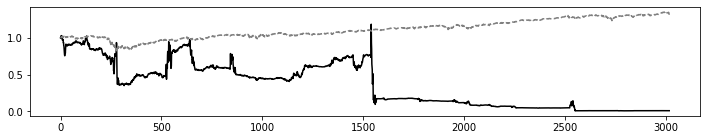

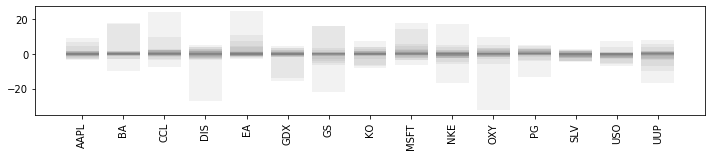

Episode 1/50 epsilon 0.9702989999999999


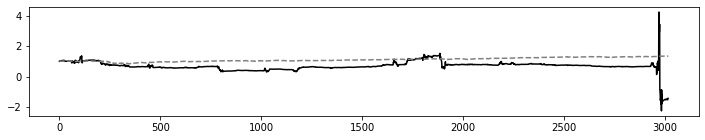

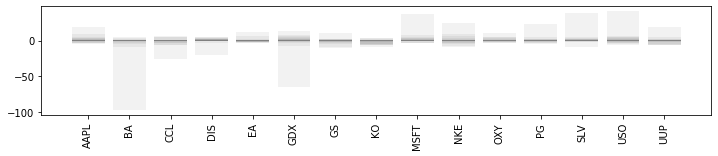

Episode 2/50 epsilon 0.9414801494009999


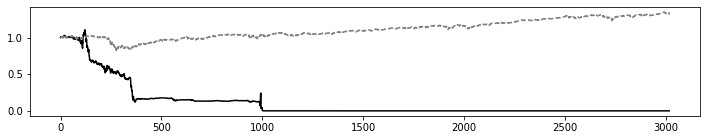

Episode 3/50 epsilon 0.9135172474836407


Episode 4/50 epsilon 0.8775210229989678


Episode 5/50 epsilon 0.8514577710948754


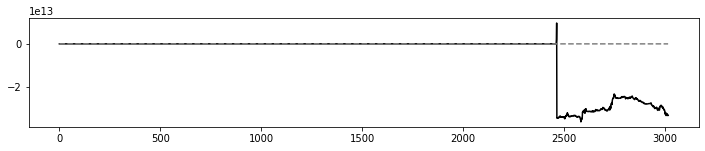

Episode 6/50 epsilon 0.8261686238355865


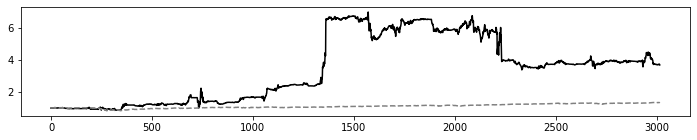

Episode 7/50 epsilon 0.8016305895390458


Episode 8/50 epsilon 0.7700431458051551


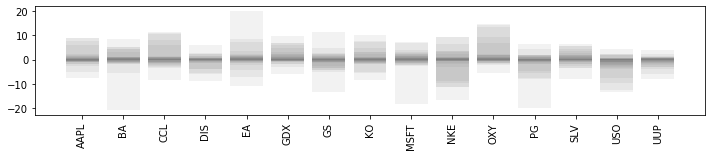

Episode 9/50 epsilon 0.7471720943315961


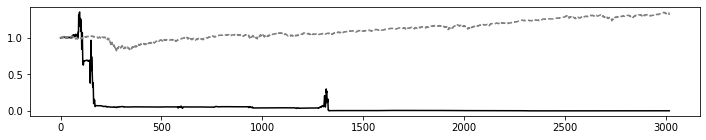

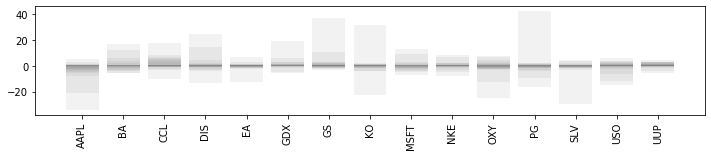

Episode 10/50 epsilon 0.7249803359578534


Episode 11/50 epsilon 0.7034476949995692


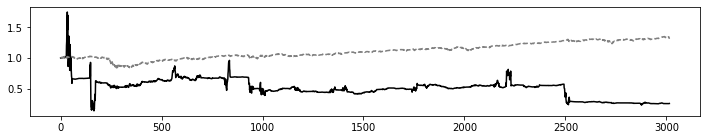

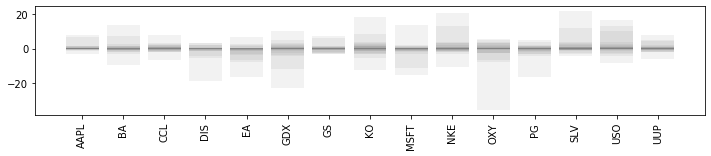

Episode 12/50 epsilon 0.6757290490602831


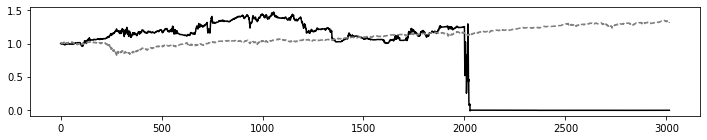

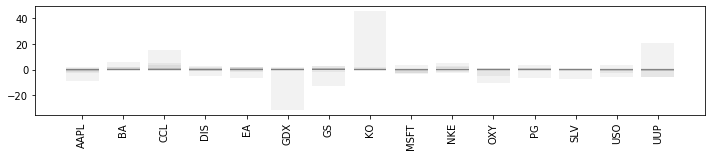

Episode 13/50 epsilon 0.6556592205741436


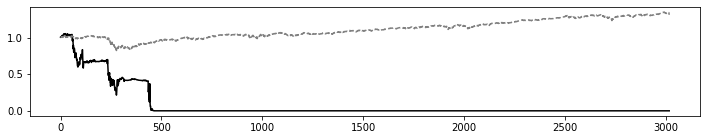

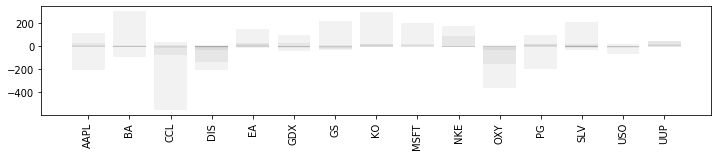

Episode 14/50 epsilon 0.6361854860638709


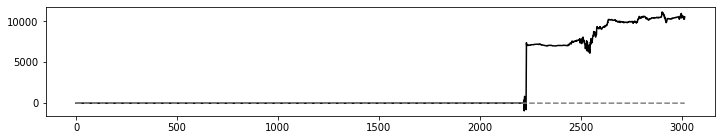

Episode 15/50 epsilon 0.617290140942288


Episode 16/50 epsilon 0.5929664464014994


Episode 17/50 epsilon 0.5753547499769285


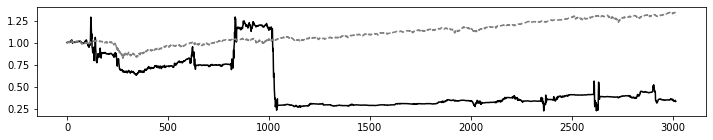

Episode 18/50 epsilon 0.5582661385478638


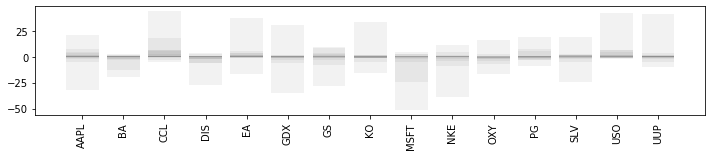

Episode 19/50 epsilon 0.5416850759668536


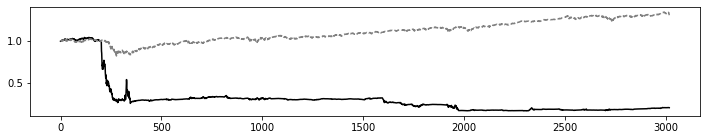

Episode 20/50 epsilon 0.5203405226503064


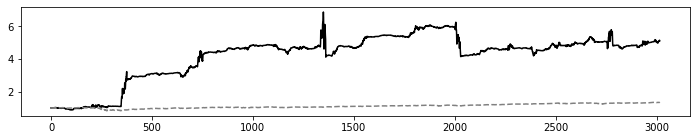

Episode 21/50 epsilon 0.5048858887870696


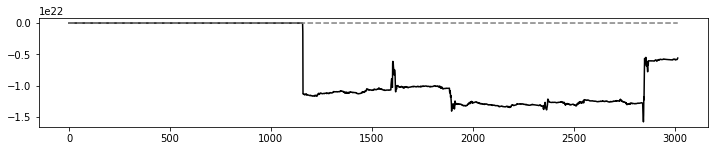

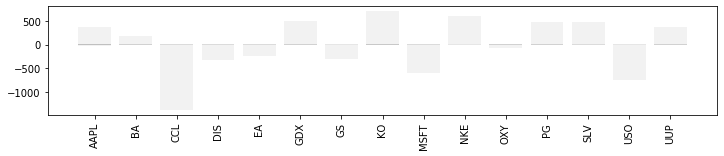

Episode 22/50 epsilon 0.4898902730042049


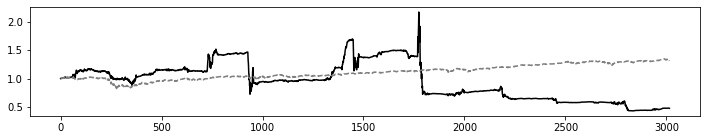

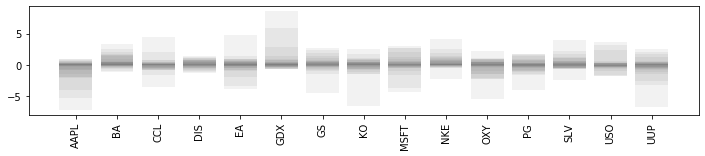

Episode 23/50 epsilon 0.475340042005707


Episode 24/50 epsilon 0.45660974774391455


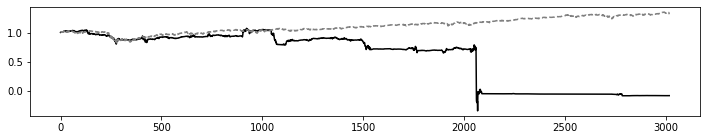

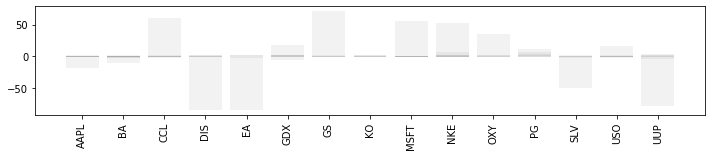

Episode 25/50 epsilon 0.44304798162617254


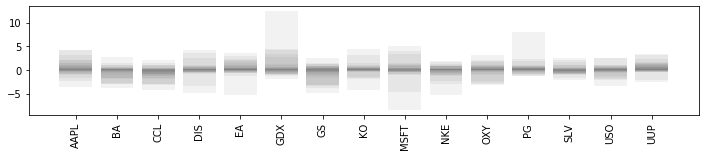

Episode 26/50 epsilon 0.4298890135238936


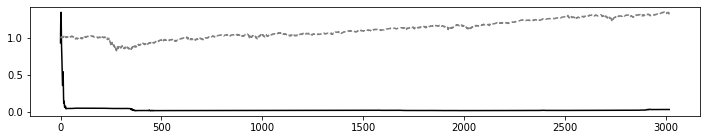

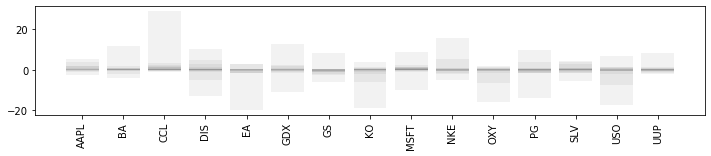

Episode 27/50 epsilon 0.41712087993322045


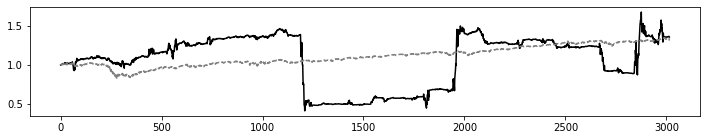

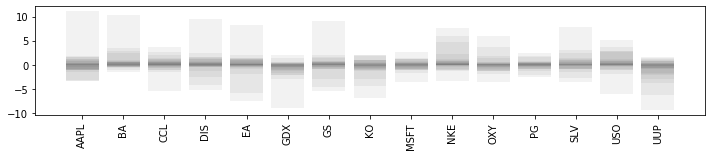

Episode 28/50 epsilon 0.40068465295154065


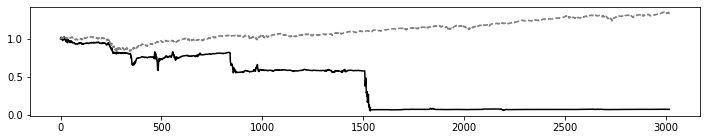

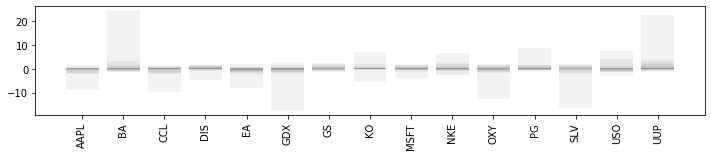

Episode 29/50 epsilon 0.38878391807422696


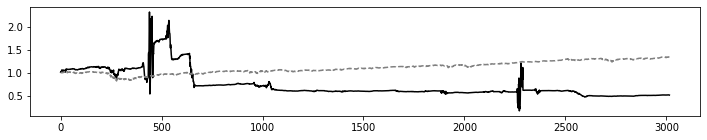

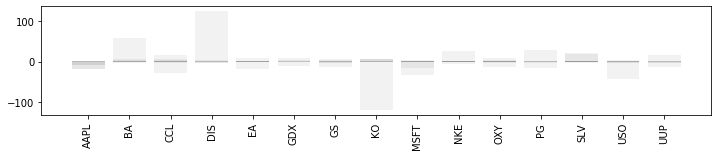

Episode 30/50 epsilon 0.37723664692350434


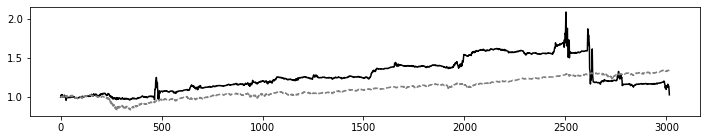

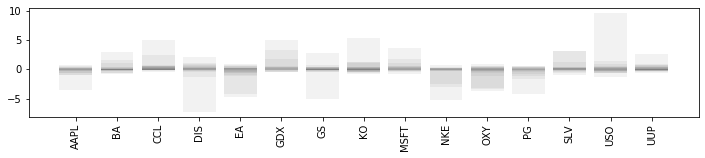

Episode 31/50 epsilon 0.36603234127322926


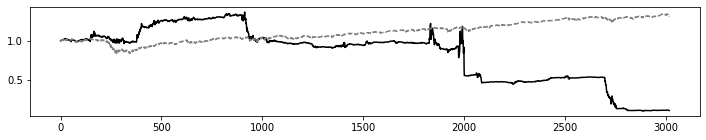

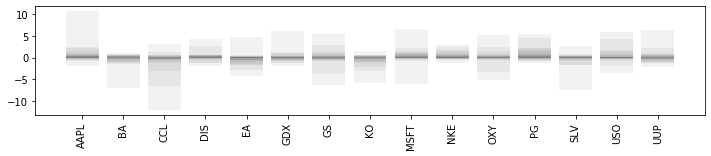

Episode 32/50 epsilon 0.3516092065580223


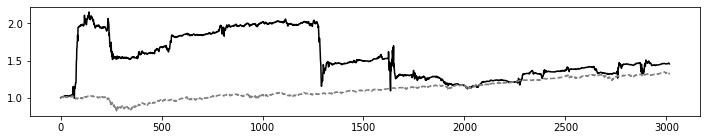

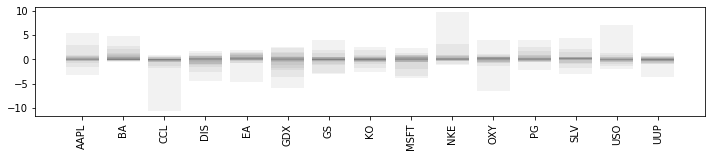

Episode 33/50 epsilon 0.34116606151404244


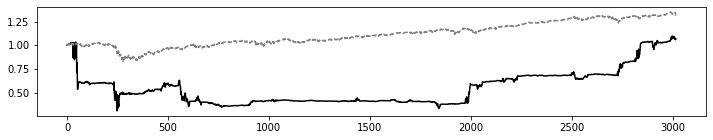

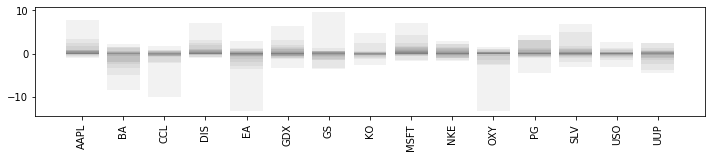

Episode 34/50 epsilon 0.33103308832101386


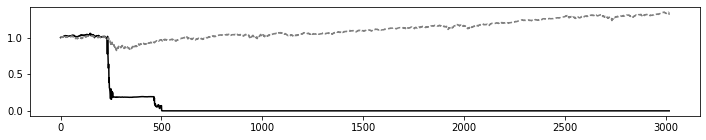

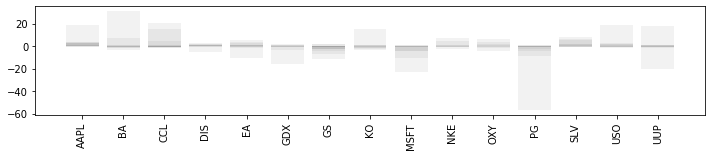

Episode 35/50 epsilon 0.3212010745647914


Episode 36/50 epsilon 0.30854447063465107


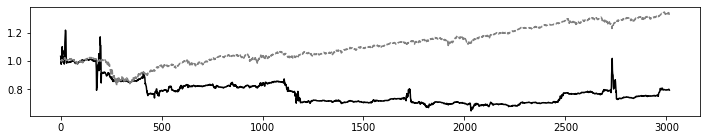

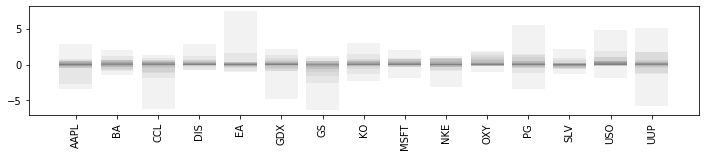

Episode 37/50 epsilon 0.29938039131233124


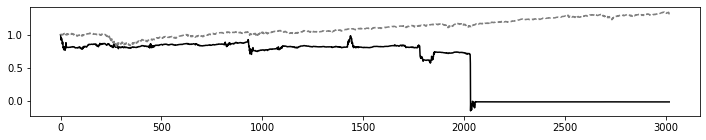

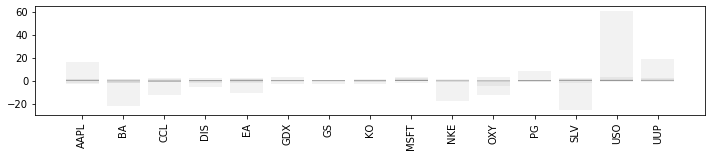

Episode 38/50 epsilon 0.2904884943099637


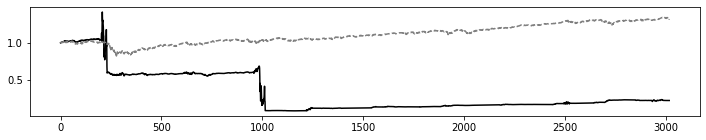

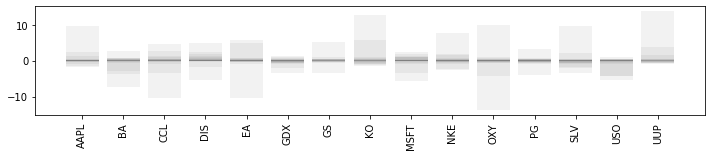

Episode 39/50 epsilon 0.28186069554046345


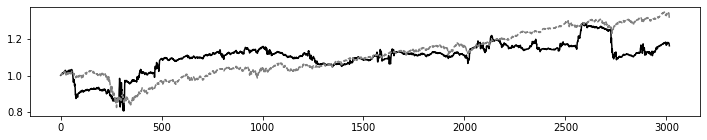

Episode 40/50 epsilon 0.270754259511994


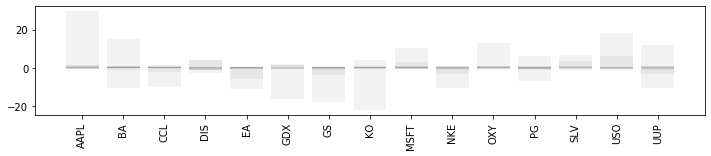

Episode 41/50 epsilon 0.2627125872502282


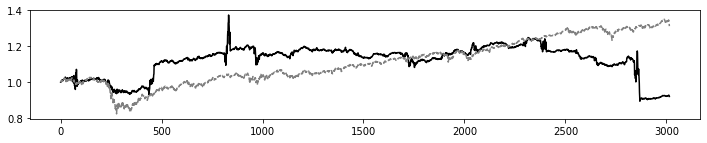

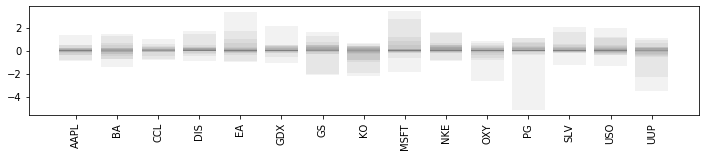

Episode 42/50 epsilon 0.2549097606963092


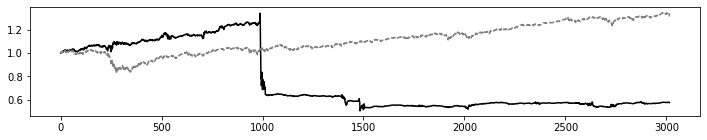

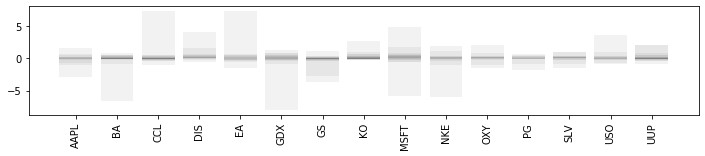

Episode 43/50 epsilon 0.24733868589386815


Episode 44/50 epsilon 0.23759255478829303


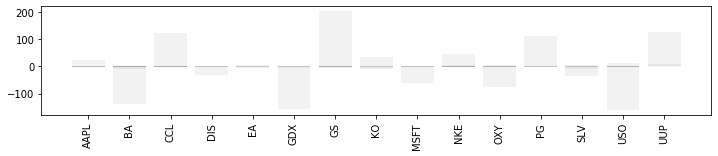

Episode 45/50 epsilon 0.23053581831852593


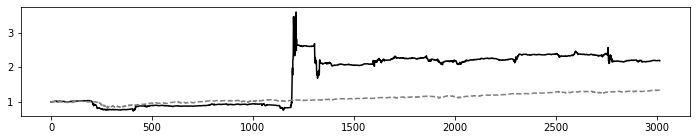

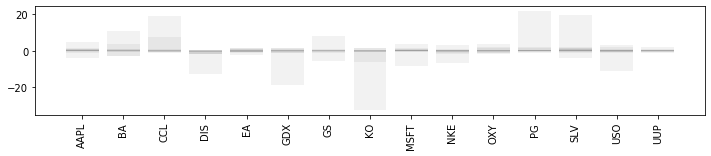

Episode 46/50 epsilon 0.22368867397864742


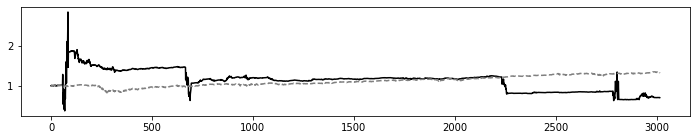

Episode 47/50 epsilon 0.2170448966728076


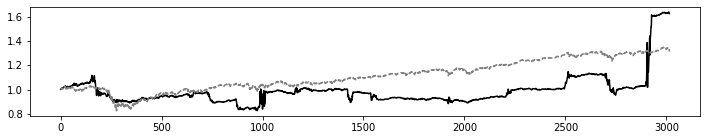

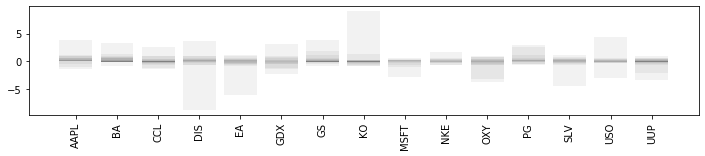

Episode 48/50 epsilon 0.20849246173476127


Episode 49/50 epsilon 0.20230002712877712


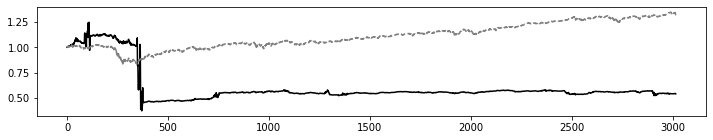

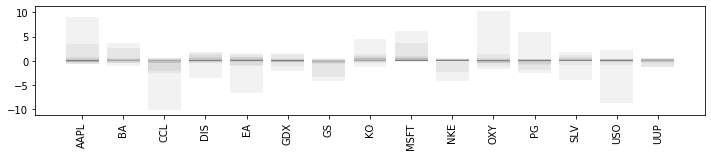

In [9]:
for e in range(episode_count):
    
    agent.is_eval = False
    data_length = len(env.data)
    
    returns_history = []
    returns_history_equal = []
    
    rewards_history = []
    equal_rewards = []
    
    actions_to_show = []
    
    print("Episode " + str(e) + "/" + str(episode_count), 'epsilon', agent.epsilon)

    s = env.get_state(np.random.randint(window_size+1, data_length-window_size-1), window_size)
    # np.random.randint(1,5) # 返回1个[1,5)时间的随机整数
    total_profit = 0 

    for t in range(window_size, data_length, rebalance_period):
        # 3个参数：start, stop, step

        date1 = t-rebalance_period
   
        #date1 就是隔九十天一个
        s_ = env.get_state(t, window_size)
        action = agent.act(s_)
        # action every 90 days
    
        
        actions_to_show.append(action[0])
        #这里会输出 动作 就是各个股票的weight

        weighted_returns, reward = env.get_reward(action[0], date1, t)
        # weighted return是每天的
        weighted_returns_equal, reward_equal = env.get_reward(
            np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

        rewards_history.append(reward)
        equal_rewards.append(reward_equal)
        #这里算的是sharpe ratio
    
        
        returns_history.extend(weighted_returns)
        returns_history_equal.extend(weighted_returns_equal)
        # 这里算的是回报率

        done = True if t == data_length else False
        agent.memory4replay.append((s, s_, action, reward, done))
        
        if len(agent.memory4replay) >= batch_size:
            agent.expReplay(batch_size)
            agent.memory4replay = []
        #每三十二个state一更新
            
        s = s_
   
    for i in range(len(returns_history)):
        returns_history[i]=returns_history[i]/3+1
    for i in range(len(returns_history_equal)):
        returns_history_equal[i]=returns_history_equal[i]/3+1
    
    
    rl_result = np.array(returns_history).cumprod()
    #这里的result每天都有数据，麻烦了
    equal_result = np.array(returns_history_equal).cumprod()
    
    # 回报率的累计和

    plt.figure(figsize = (12, 2))
    plt.plot(rl_result, color = 'black', ls = '-')
    plt.plot(equal_result, color = 'grey', ls = '--')
    plt.show()
    
    plt.figure(figsize = (12, 2))
    for a in actions_to_show:    
        plt.bar(np.arange(N_ASSETS), a, color = 'grey', alpha = 0.1)
        plt.xticks(np.arange(N_ASSETS), env.data.columns, rotation='vertical')
    plt.show()

In [10]:
agent.is_eval = True

actions_equal, actions_rl = [], []
result_equal, result_rl = [], []

for t in range(window_size, len(env.data), rebalance_period):

    date1 = t-rebalance_period
    s_ = env.get_state(t, window_size)
    action = agent.act(s_)

    weighted_returns, reward = env.get_reward(action[0], date1, t)
    weighted_returns_equal, reward_equal = env.get_reward(
        np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

    result_equal.append(weighted_returns_equal.tolist())
    actions_equal.append(np.ones(agent.portfolio_size) / agent.portfolio_size)
    
    result_rl.append(weighted_returns.tolist())
    actions_rl.append(action[0])

In [11]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_rl_vis = [item for sublist in result_rl for item in sublist]


In [12]:
for ph in range(len(result_equal_vis)):
        result_equal_vis[ph]=result_equal_vis[ph]/3+1
for ph in range(len(result_rl_vis)):
        result_rl_vis[ph]=result_rl_vis[ph]/3+1

<Figure size 432x288 with 0 Axes>

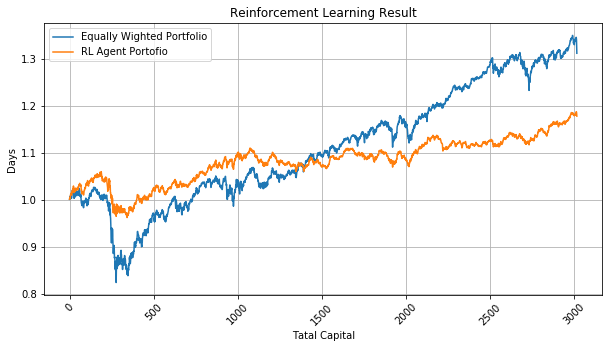

In [13]:
equally_weighted_portfolio=np.array(result_equal_vis).cumprod()
RL_agent_portfolio=np.array(result_rl_vis).cumprod()
plt.figure()

plt.figure(figsize=(10,5))
plt.xlabel("Tatal Capital")
plt.xticks(rotation=45)
plt.ylabel("Days")
plt.title('Reinforcement Learning Result')
x = range(len(equally_weighted_portfolio))
plt.plot(x,equally_weighted_portfolio,label="Equally Wighted Portfolio")
plt.plot(x,RL_agent_portfolio, label= "RL Agent Portofio")
plt.legend()
plt.grid()
plt.show()

In [14]:
r1=np.array(result_equal_vis).cumprod()
returnofequal=r1[-1]-r1[0]
r2=np.array(result_rl_vis).cumprod()
returnofrl=r2[-1]-r2[0]
sd1=np.var(r1)**0.5
sd2=np.var(r2)**0.5
sharpe1=returnofequal/sd1
sharpe2=returnofrl/sd2
print(sharpe2-sharpe1)

1.3125757405593586


In [15]:
def print_stats(result, benchmark):

    sharpe_ratio = sharpe(np.array(result).cumsum())
    returns = np.mean(np.array(result))
    volatility = np.std(np.array(result))
    
    X = benchmark
    y = result
    x = sm.add_constant(X)
    model = regression.linear_model.OLS(y, x).fit()    
    alpha = model.params[0]
    beta = model.params[1]
    
    return np.round(np.array([returns, volatility, sharpe_ratio, alpha, beta]), 4).tolist()

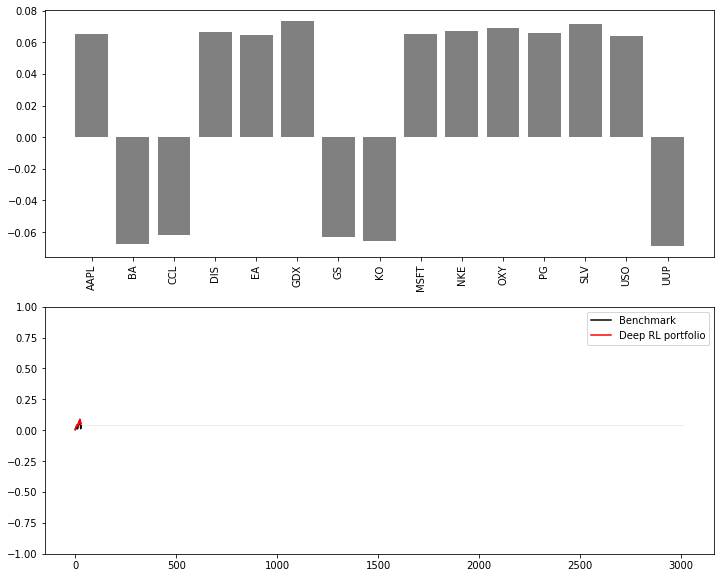

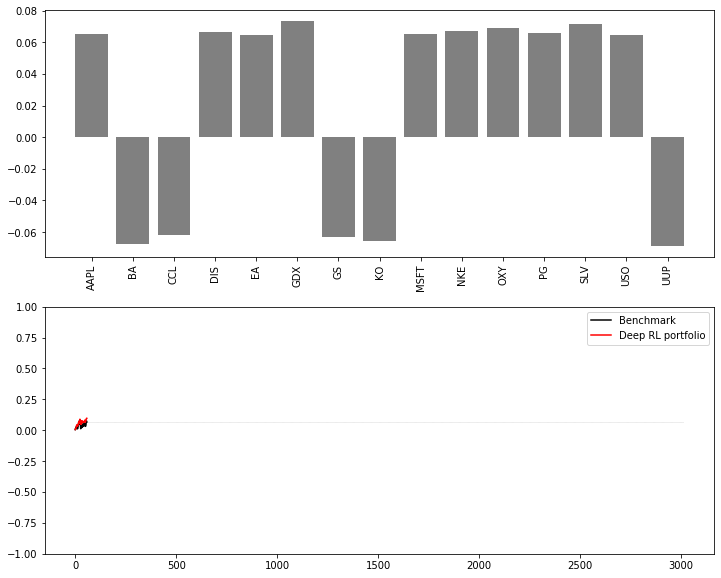

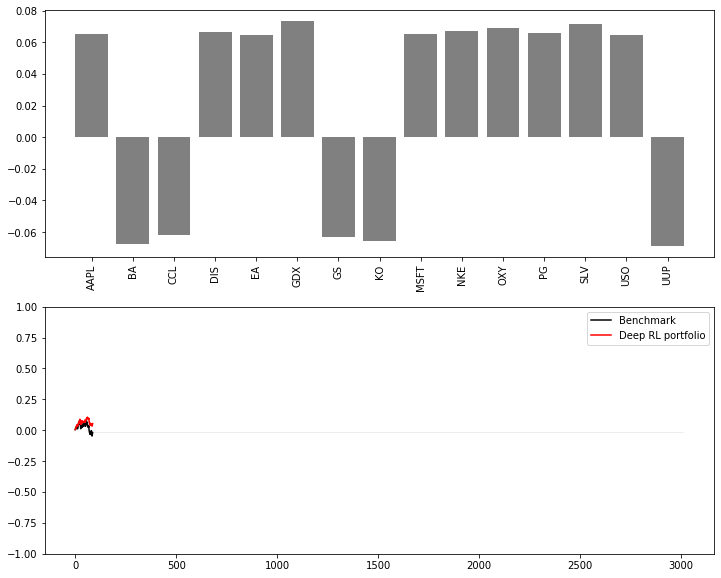

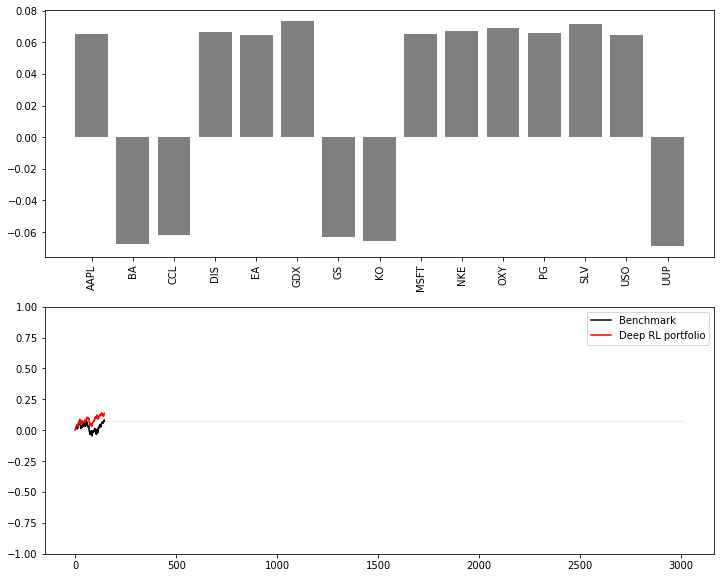

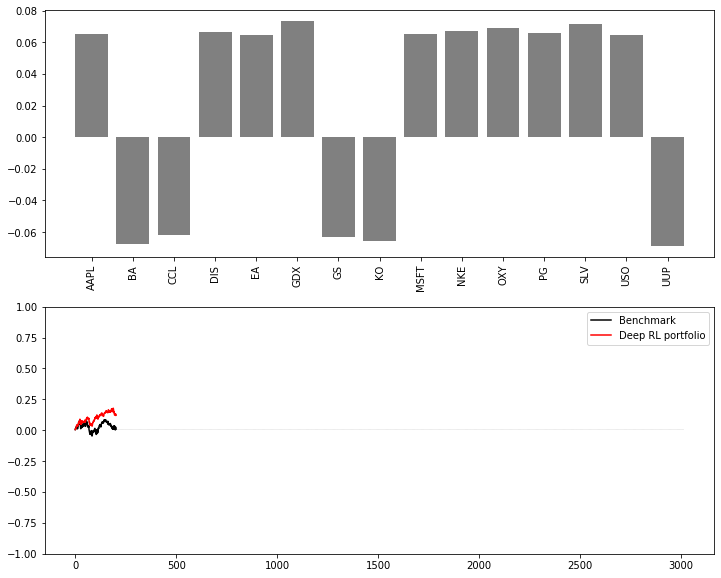

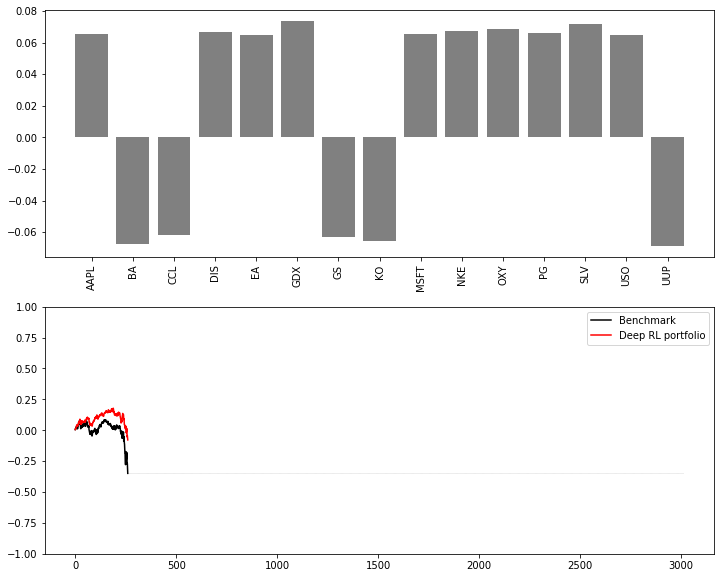

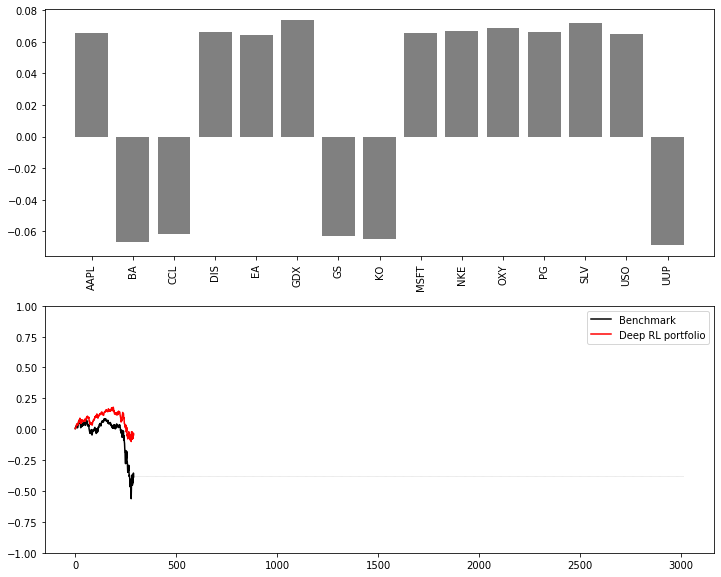

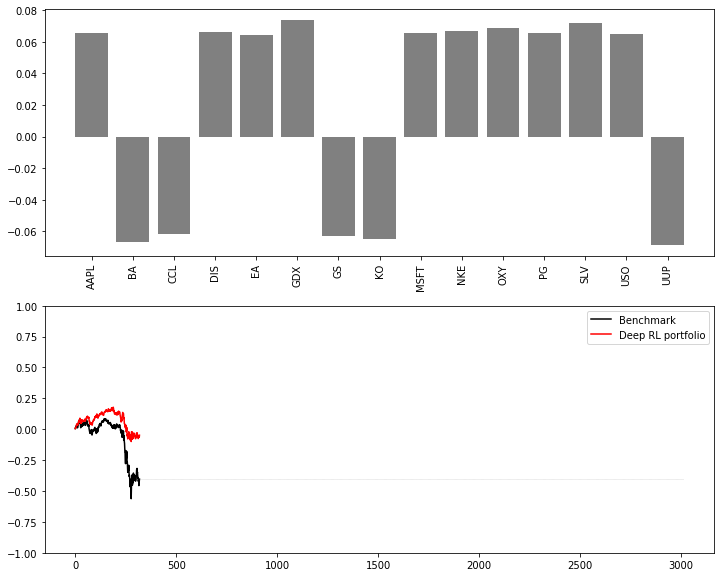

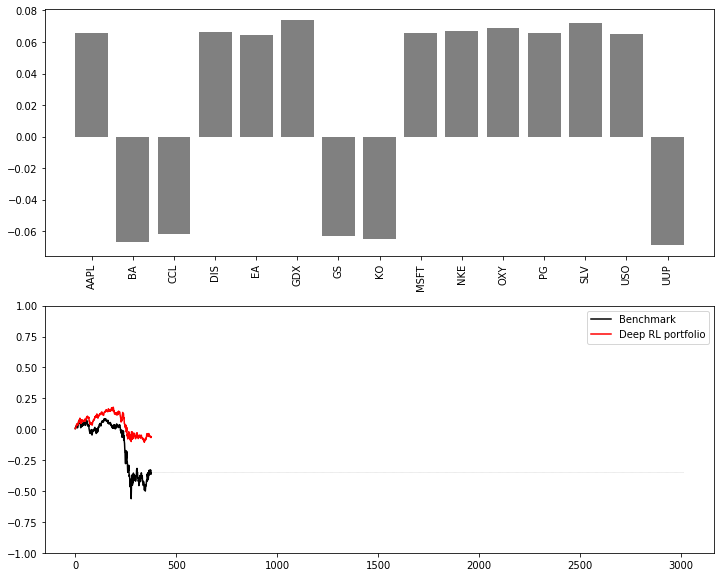

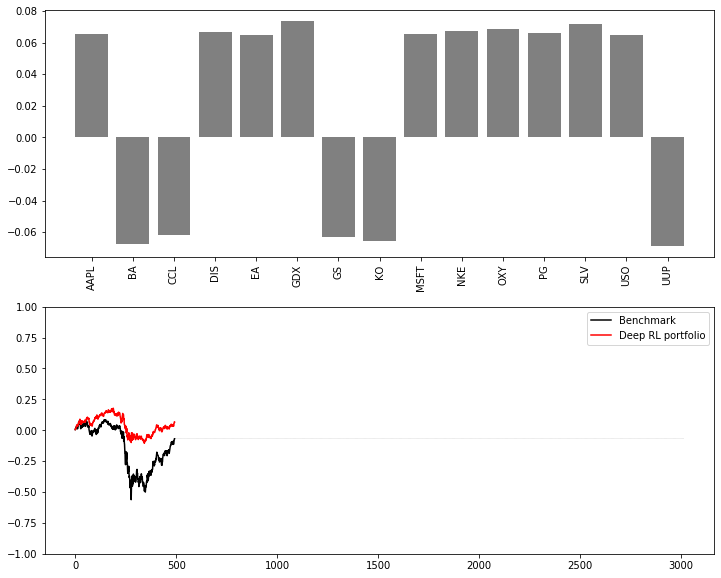

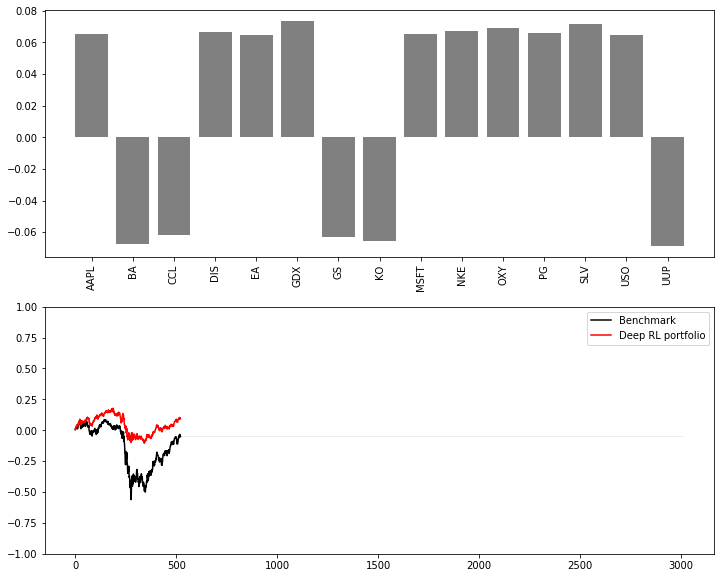

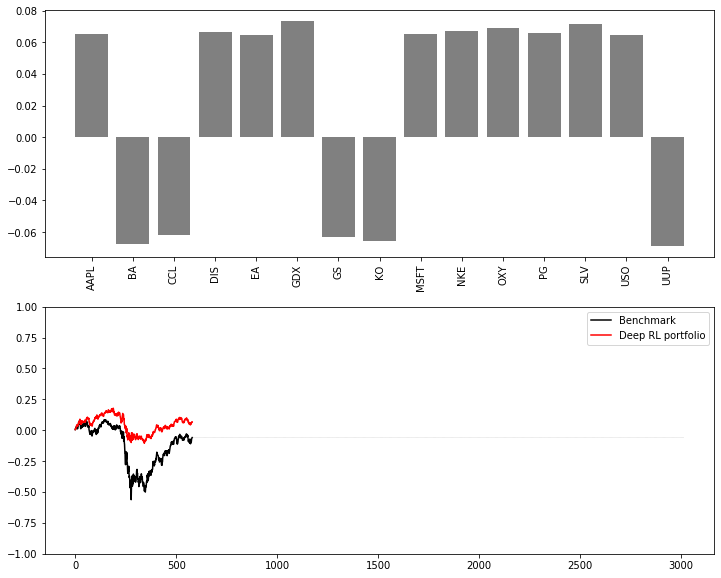

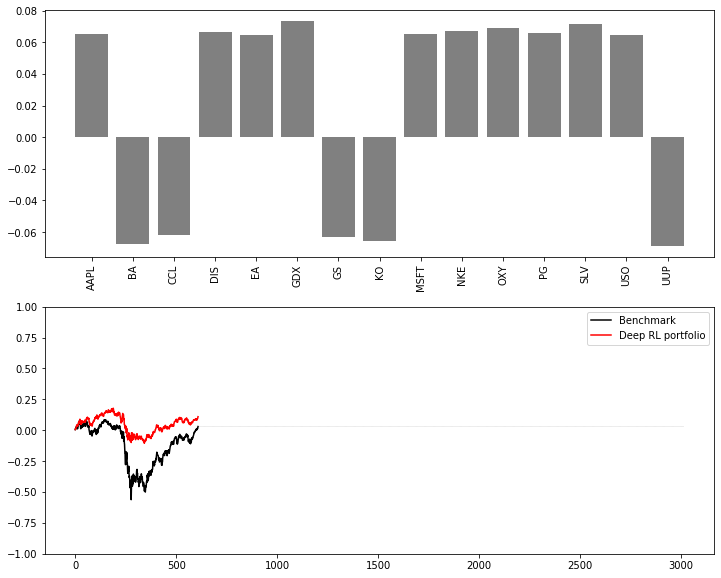

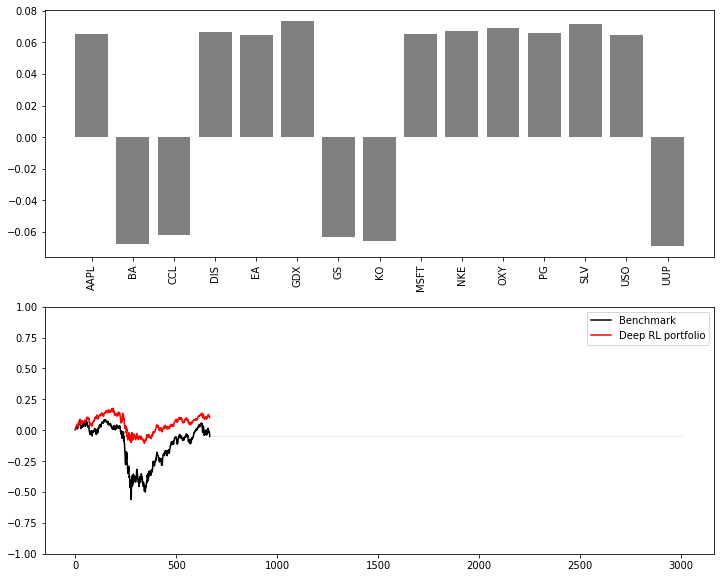

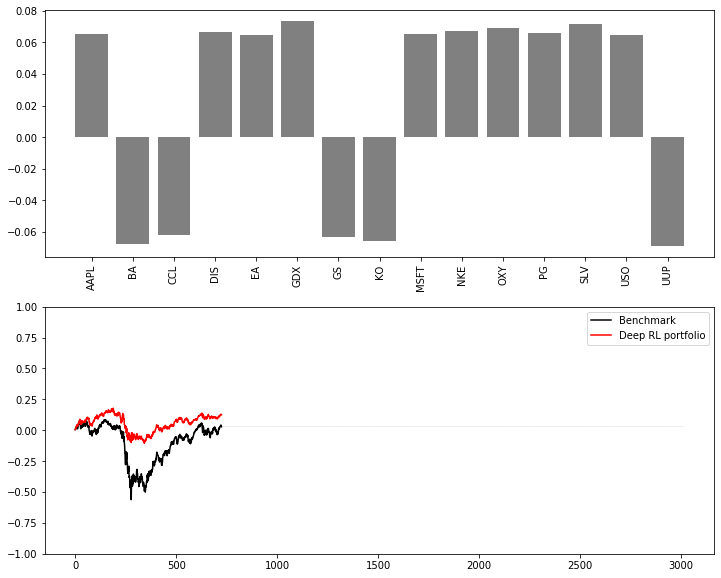

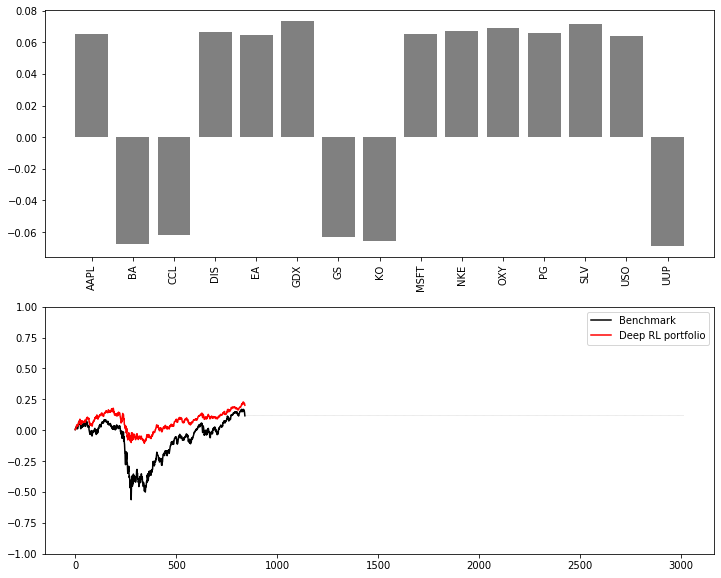

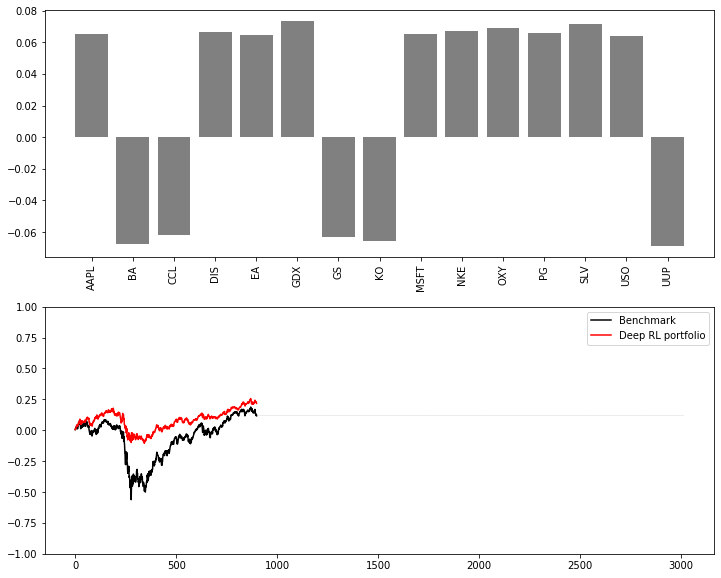

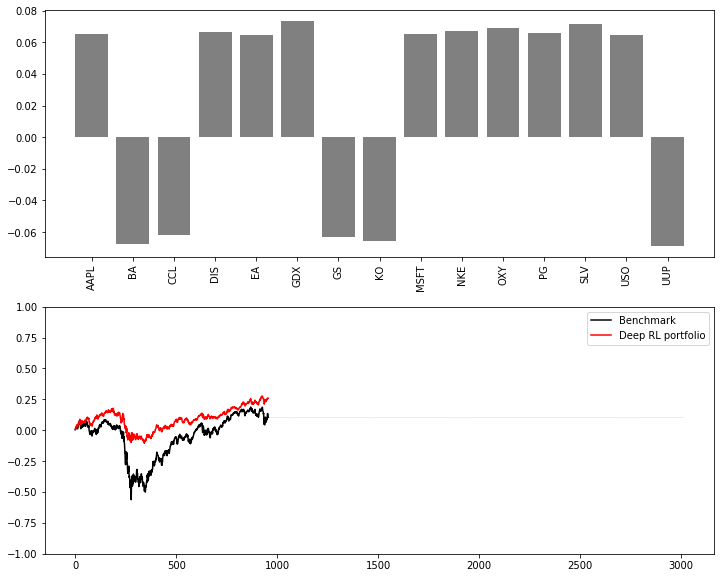

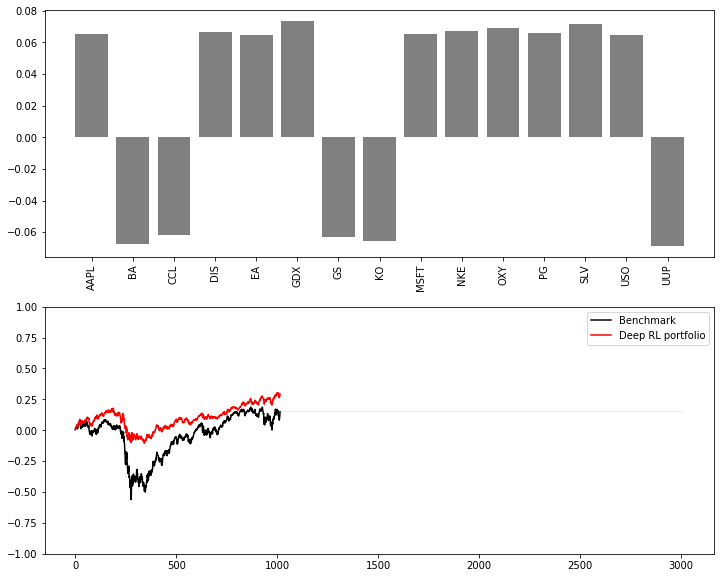

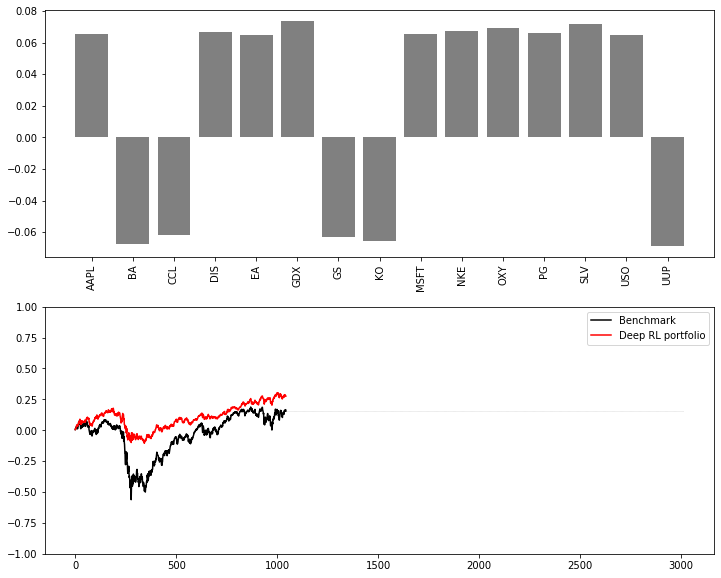

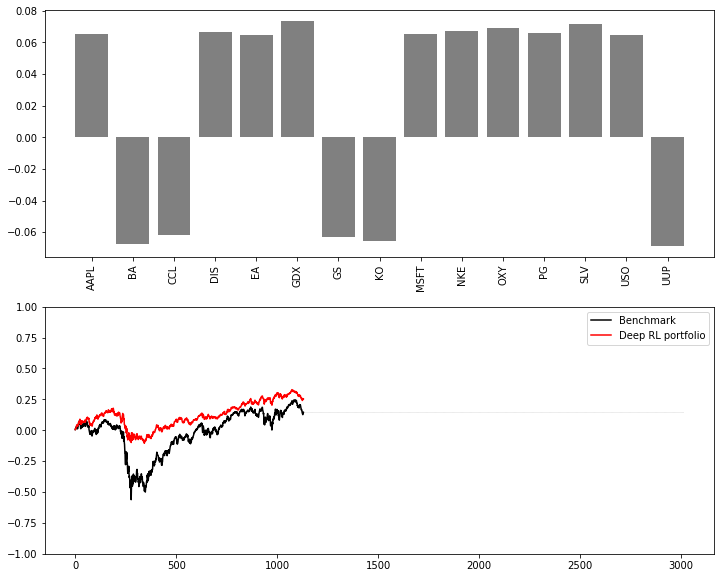

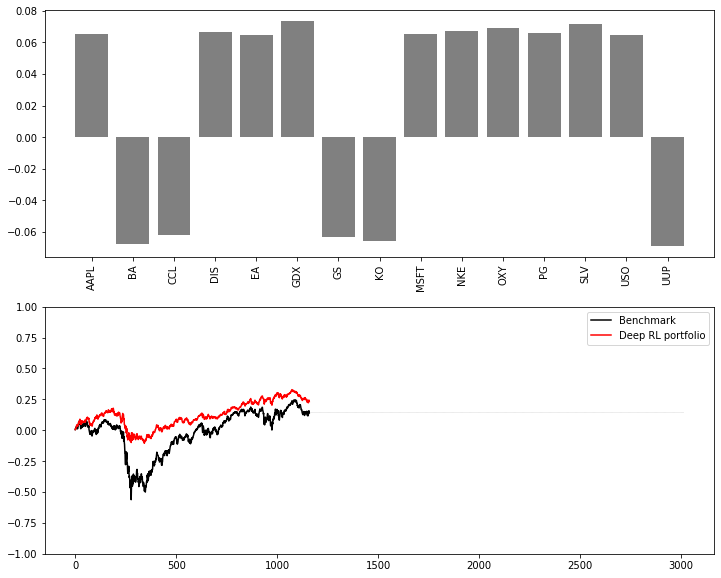

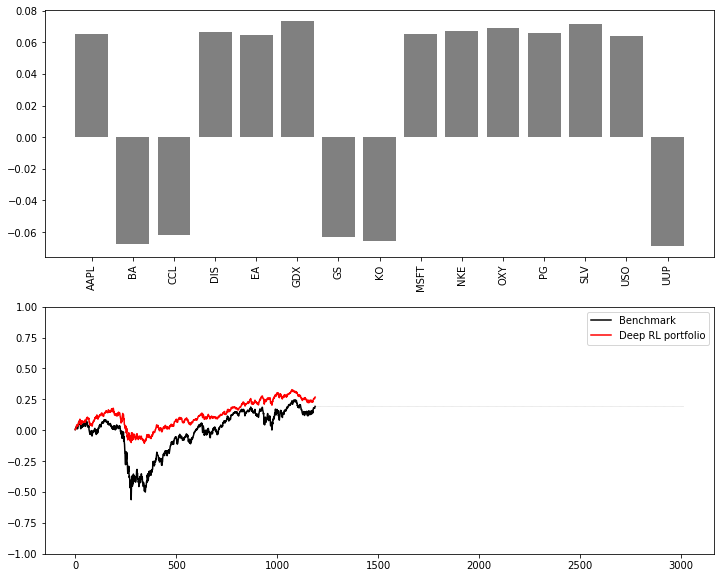

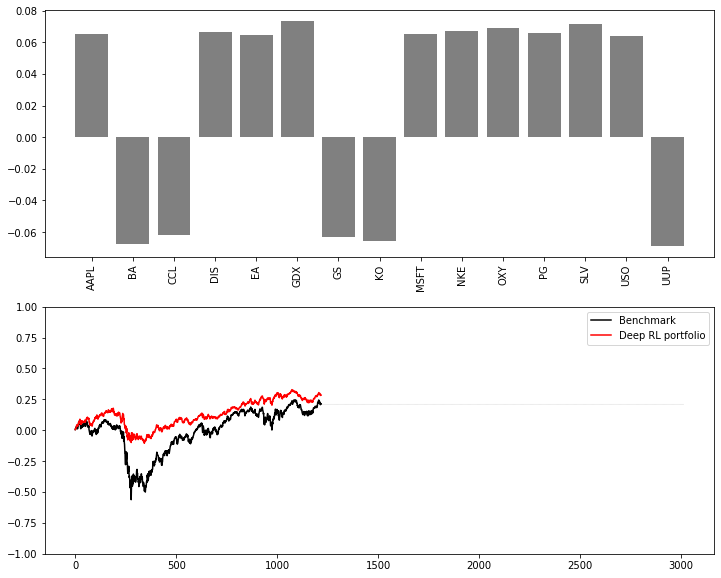

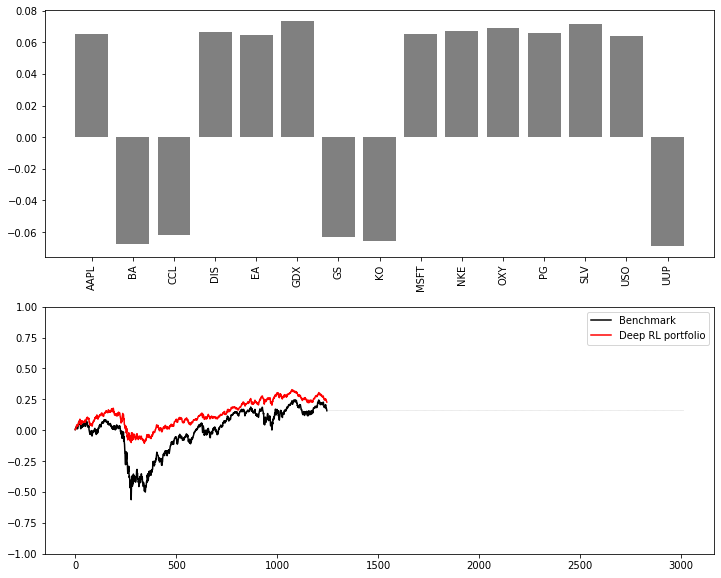

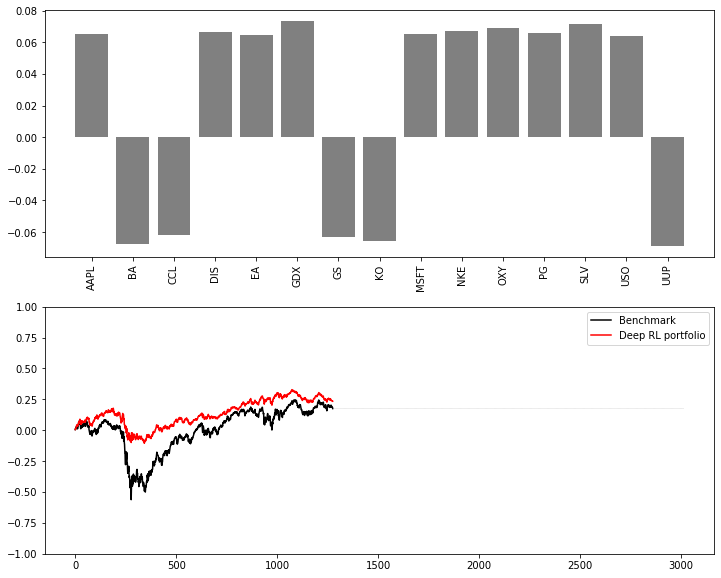

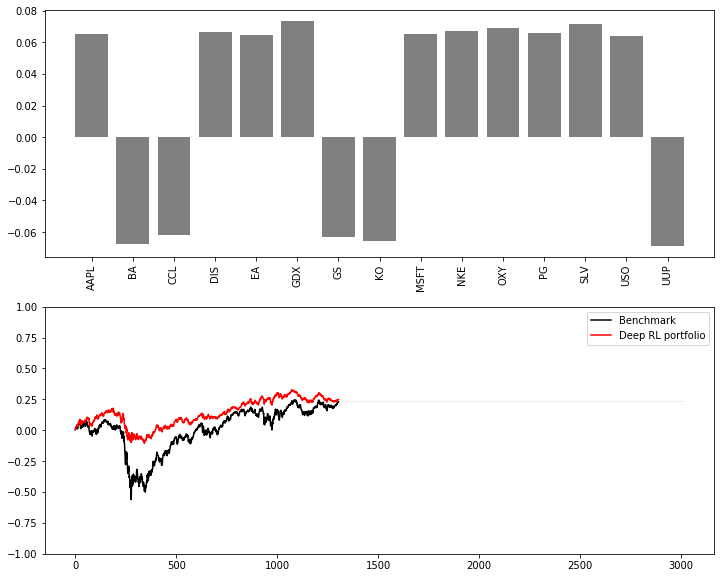

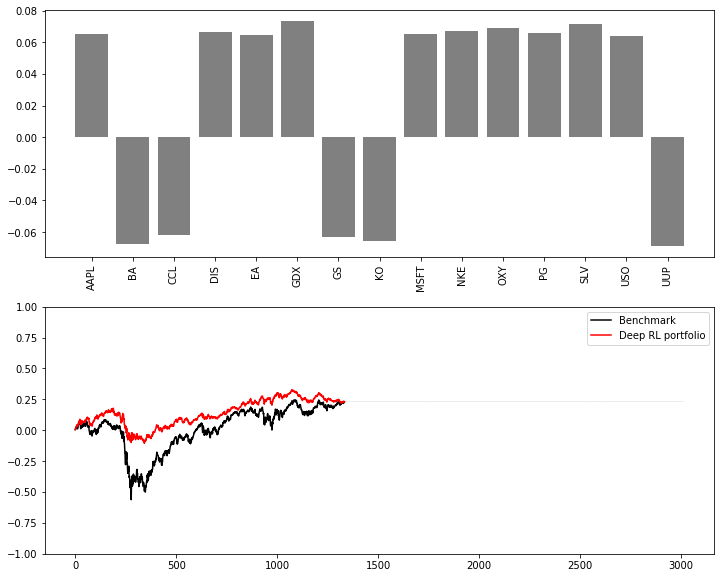

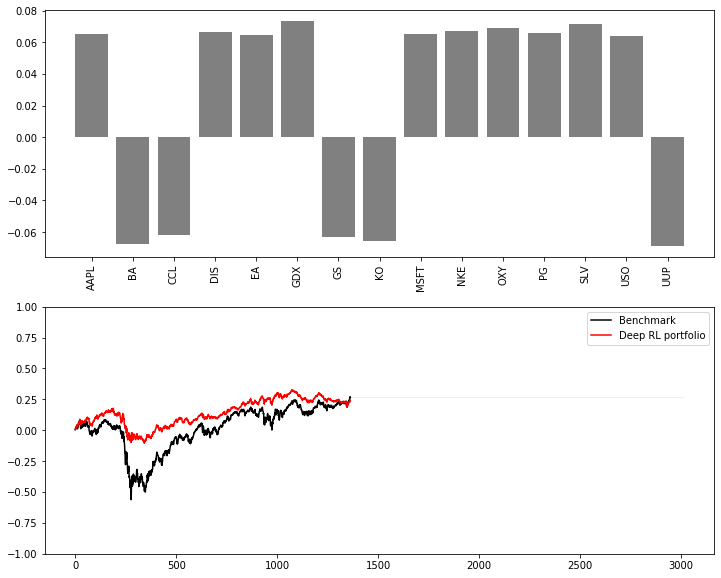

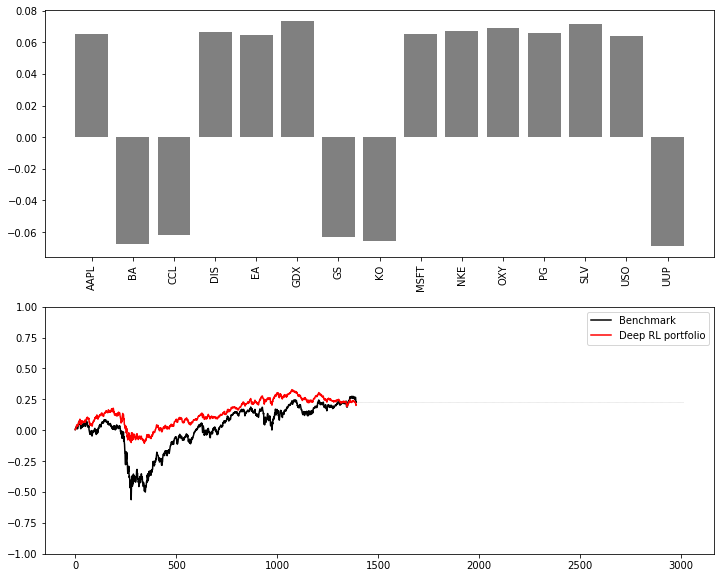

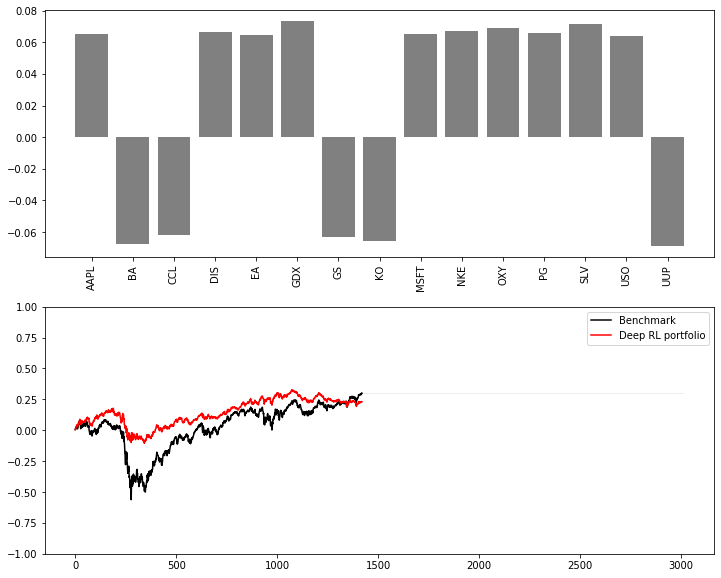

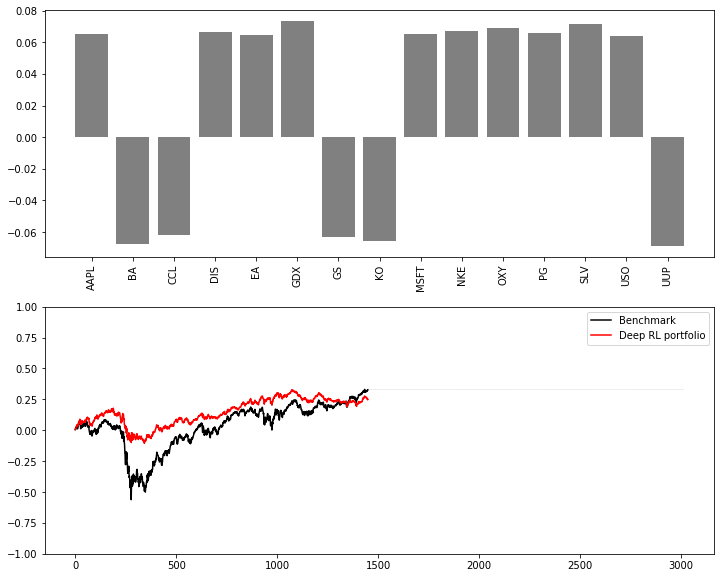

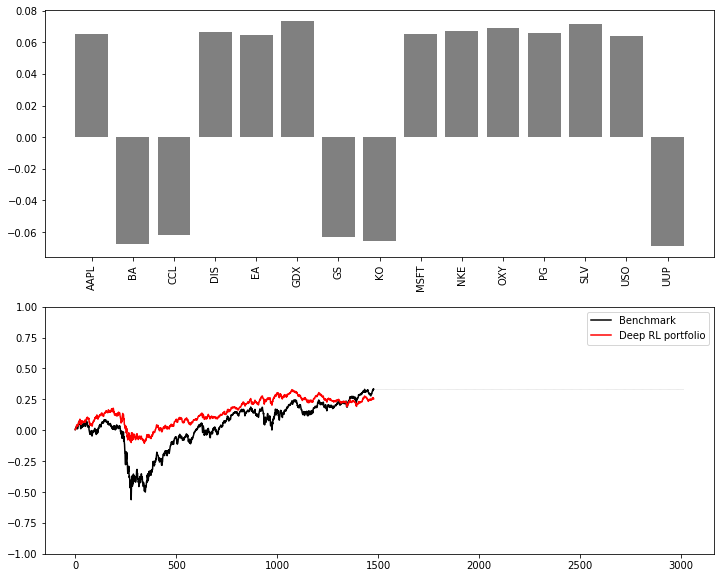

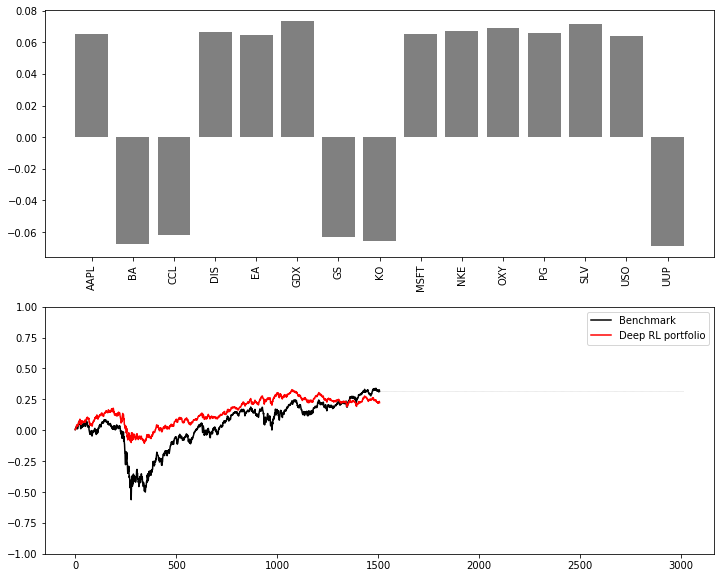

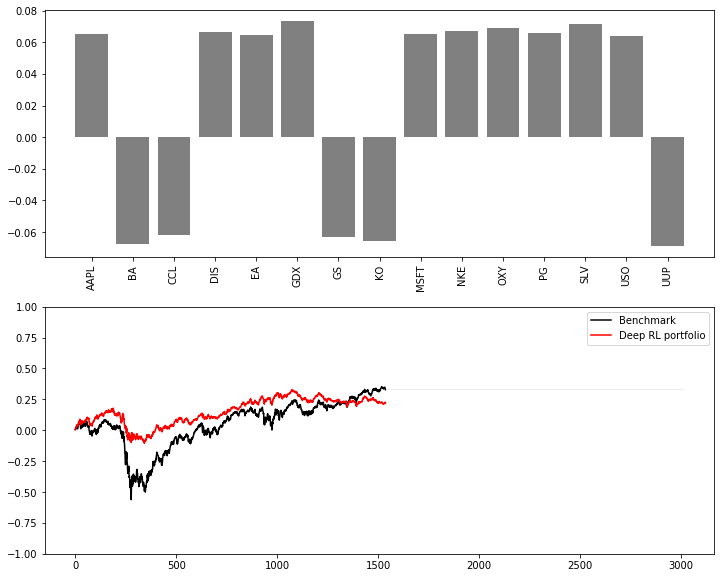

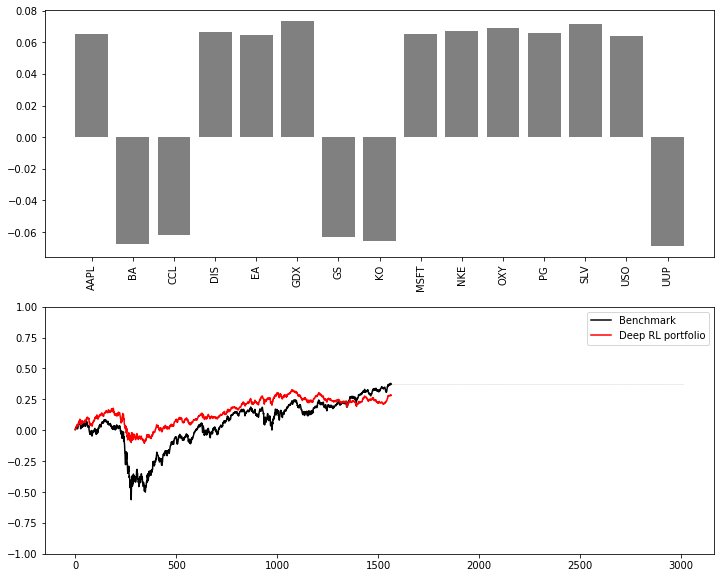

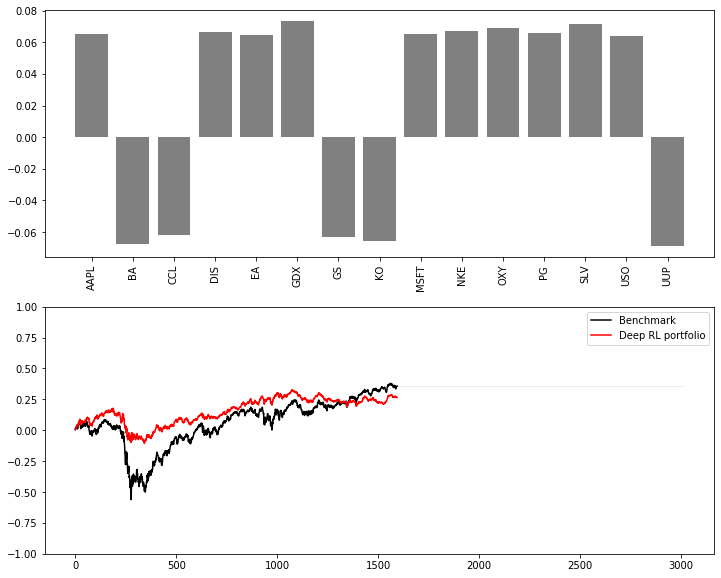

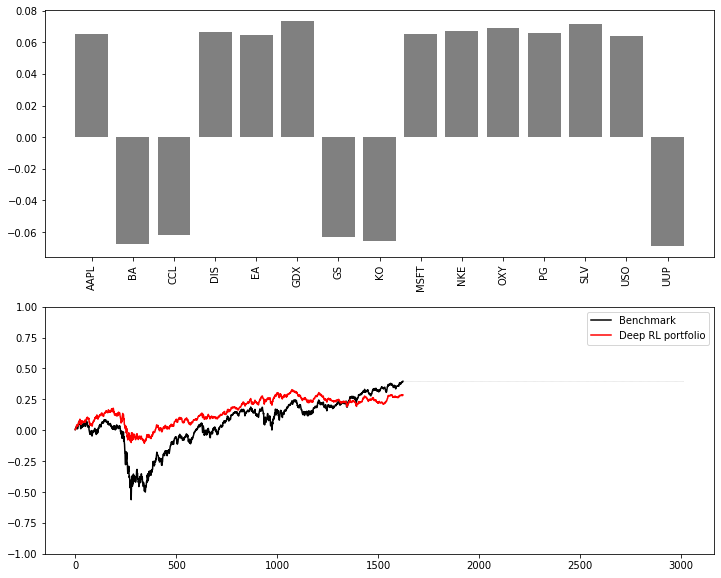

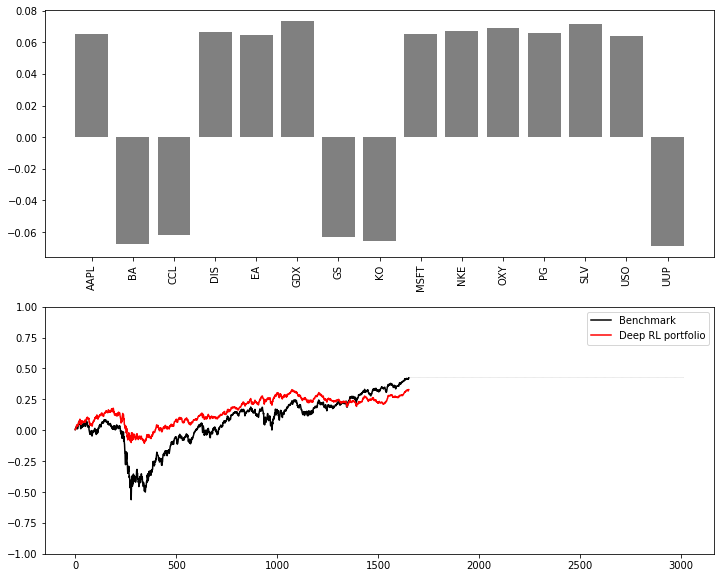

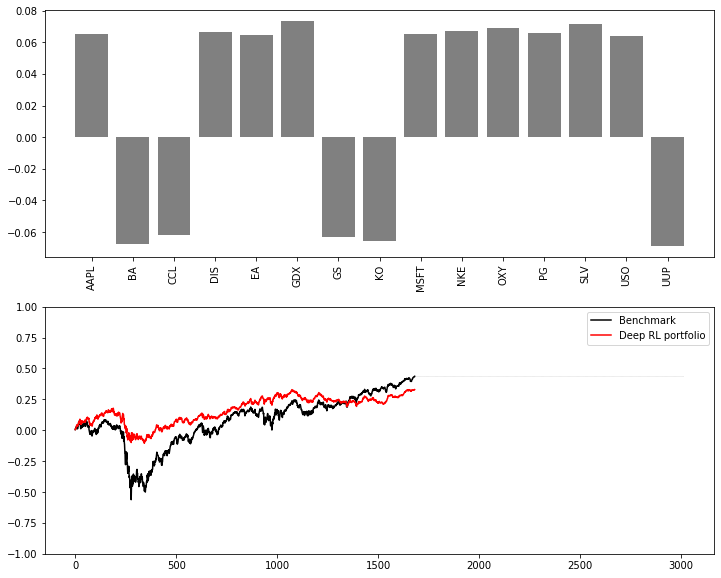

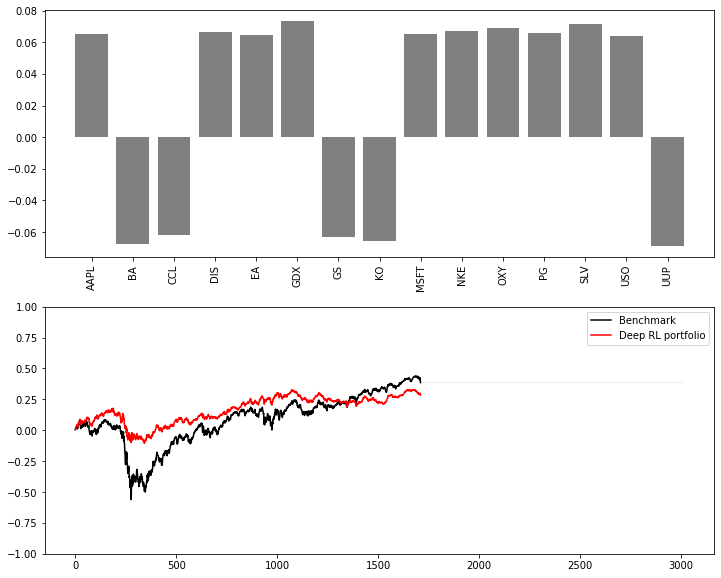

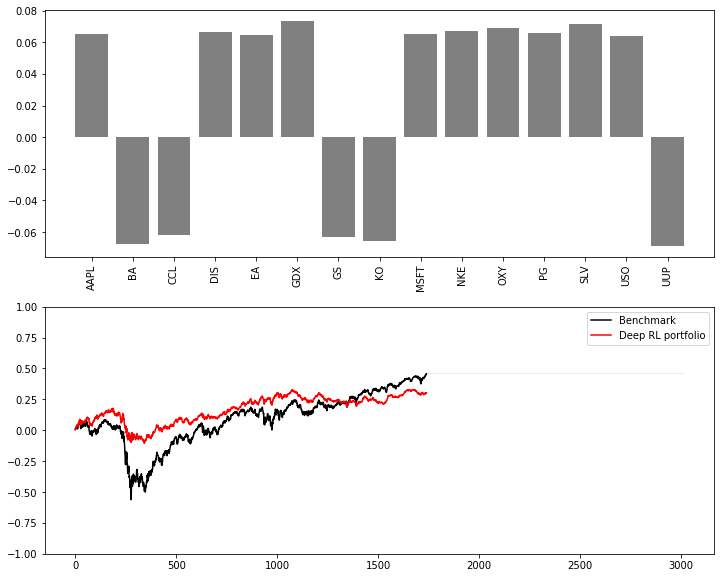

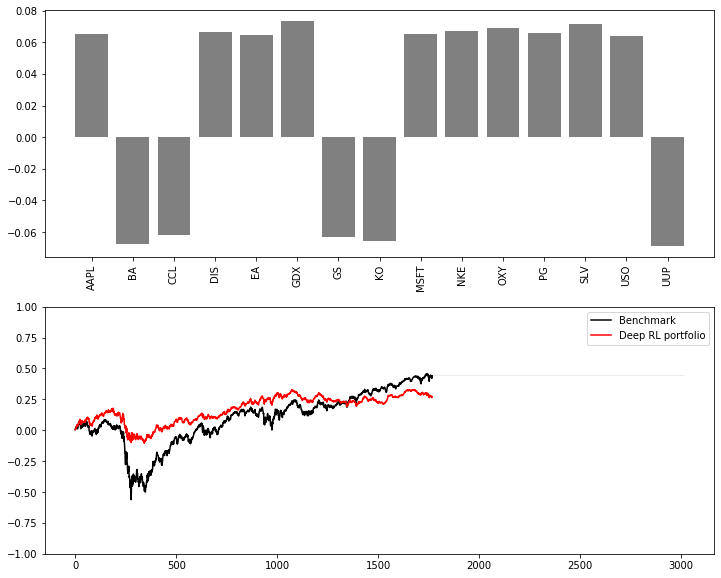

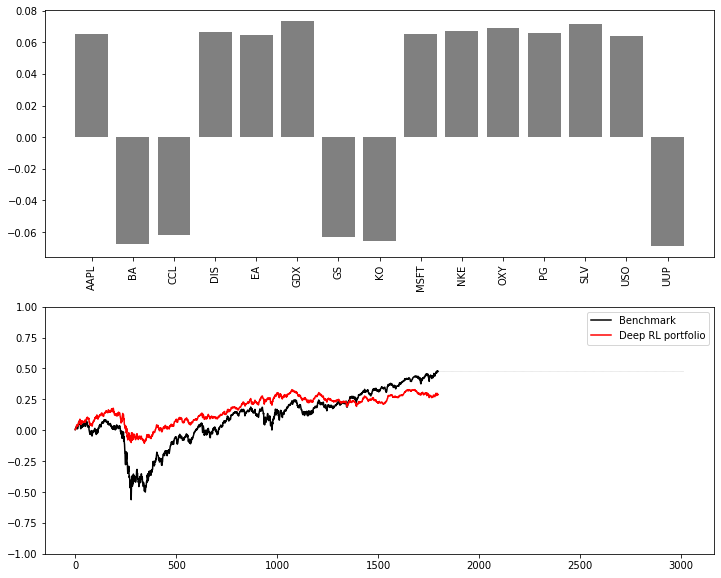

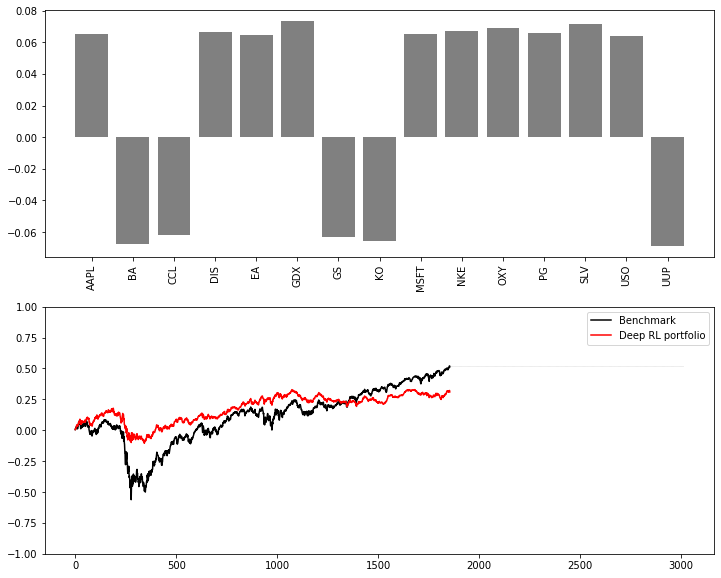

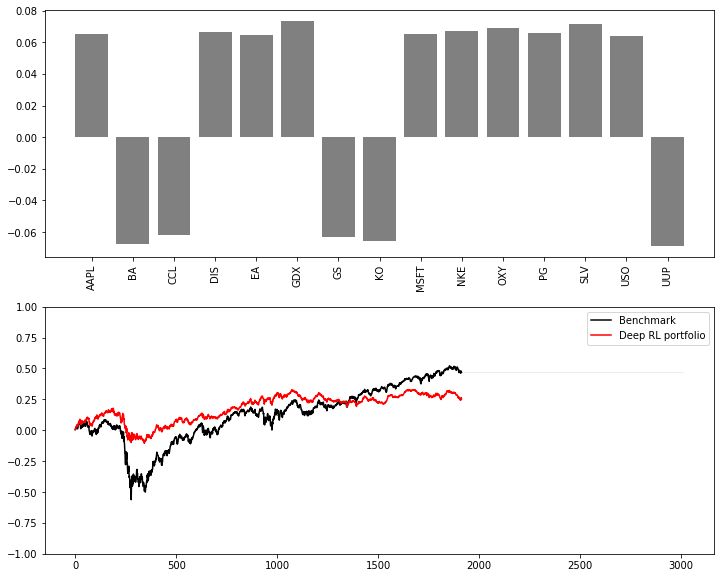

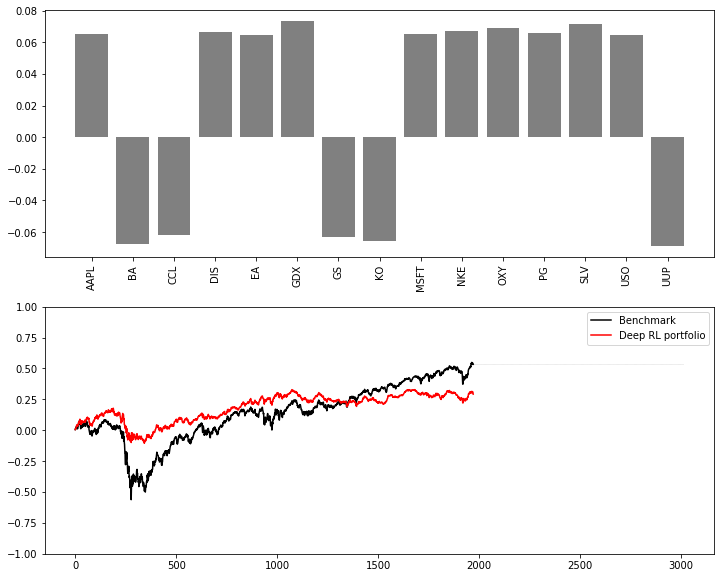

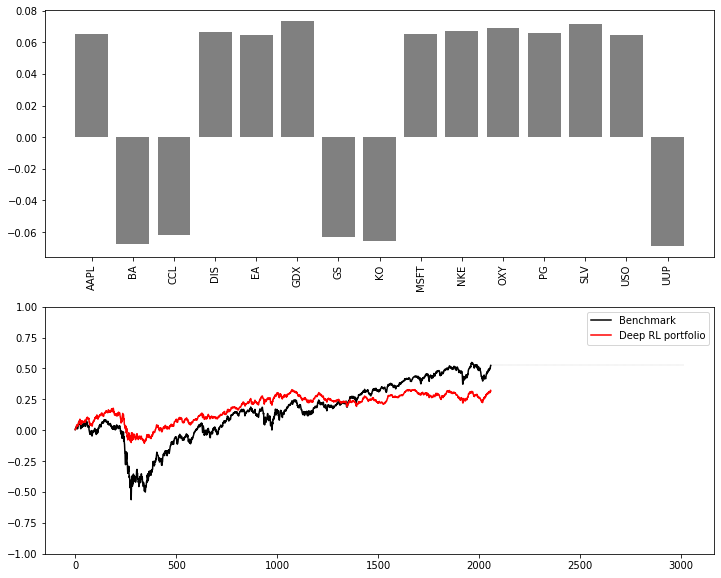

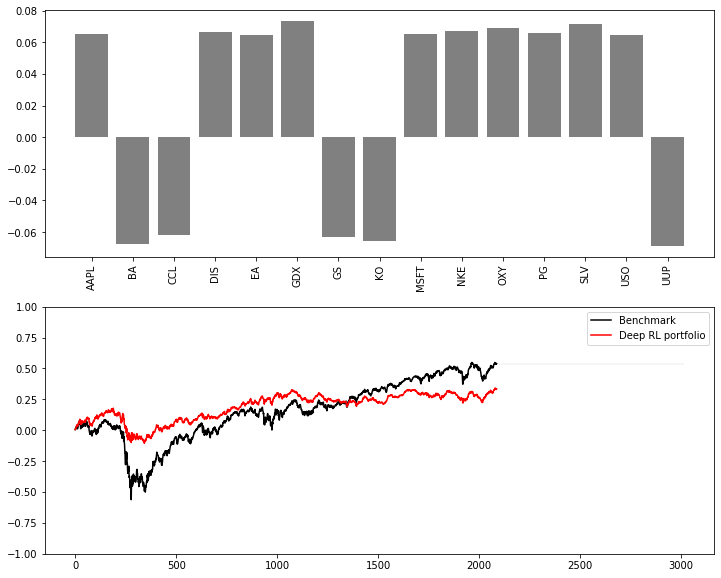

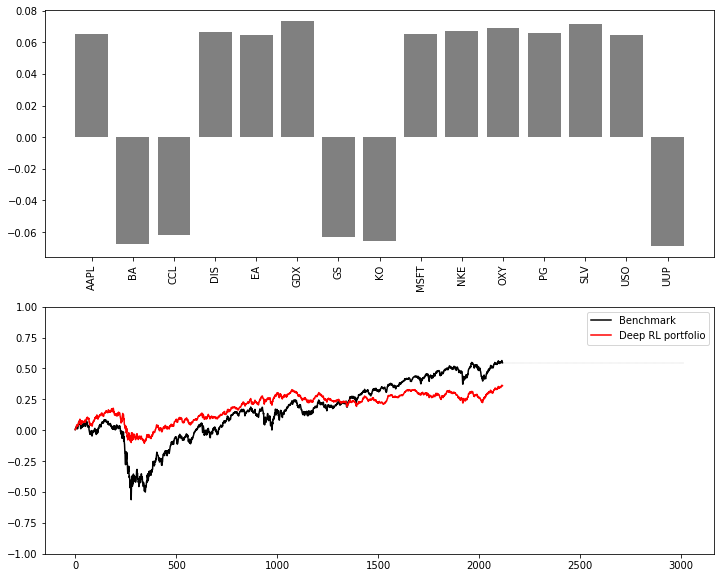

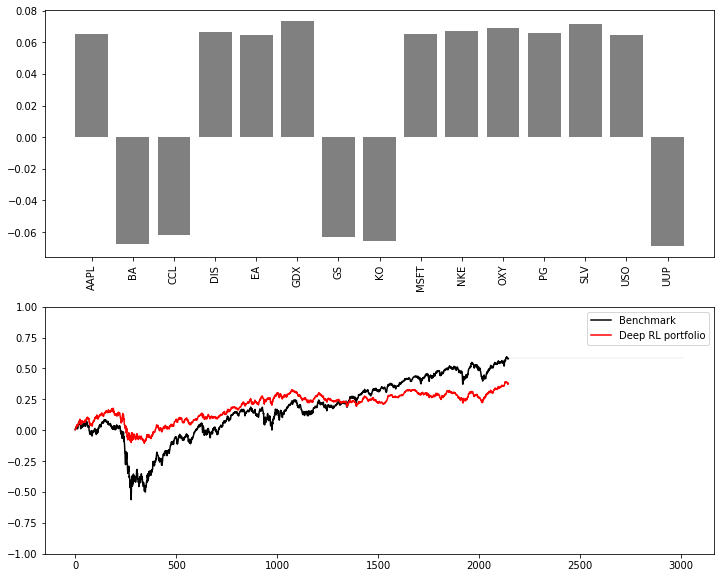

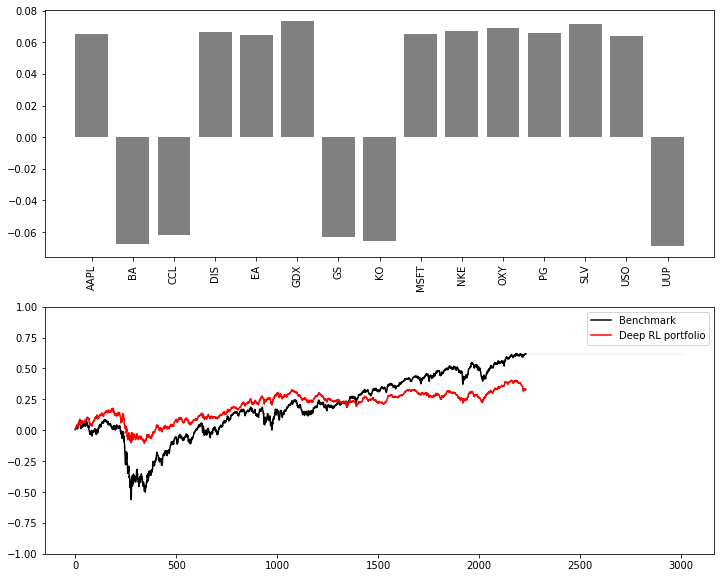

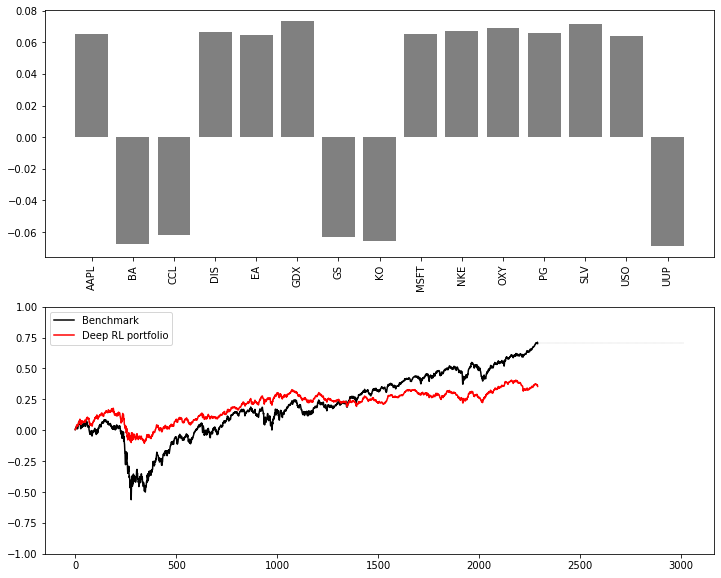

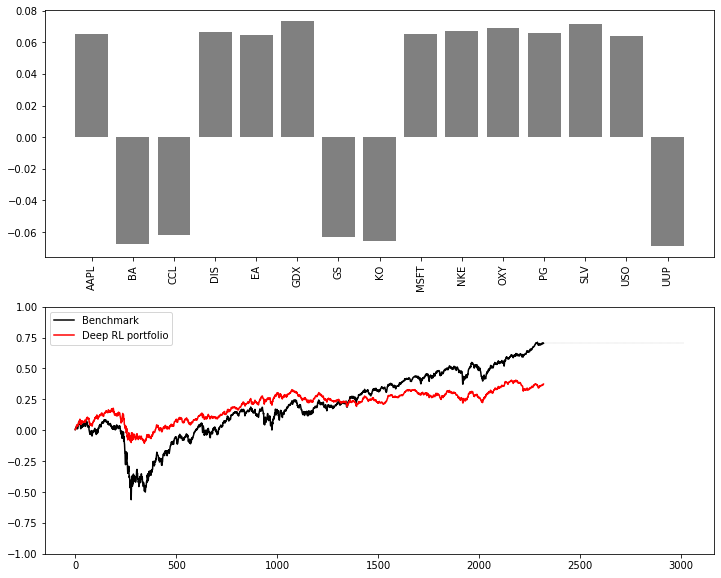

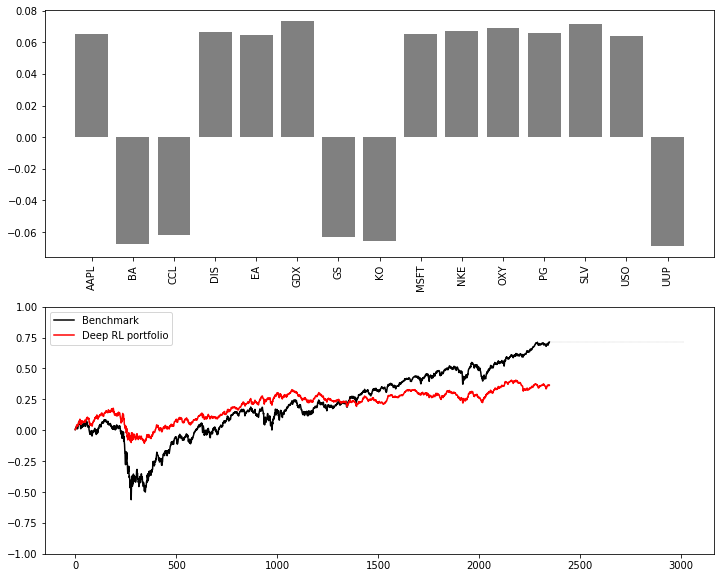

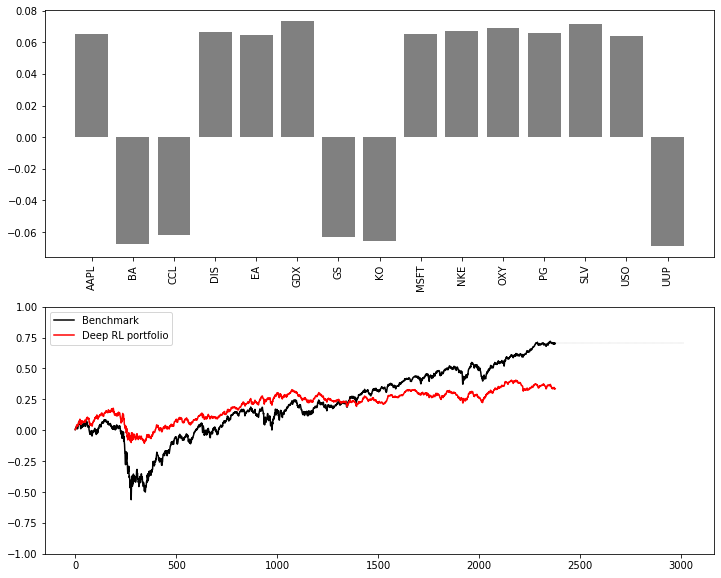

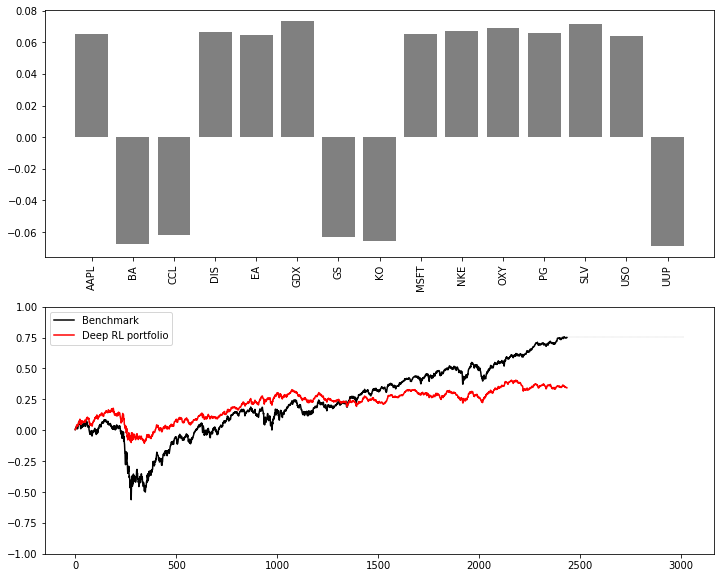

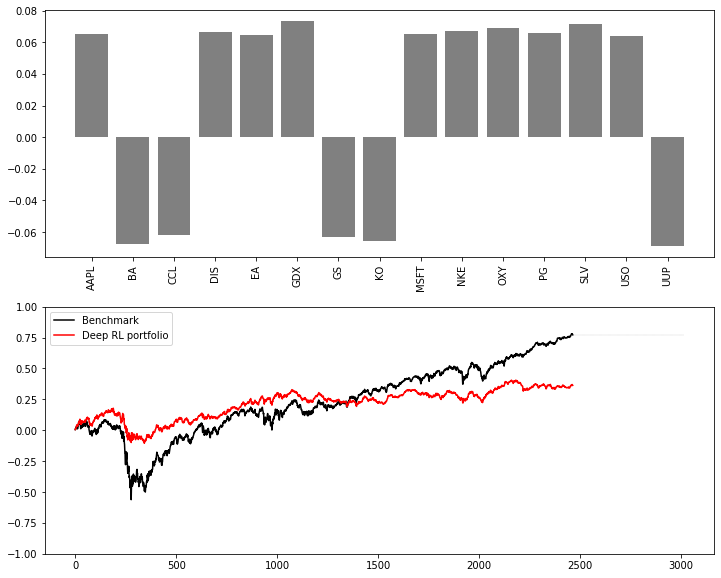

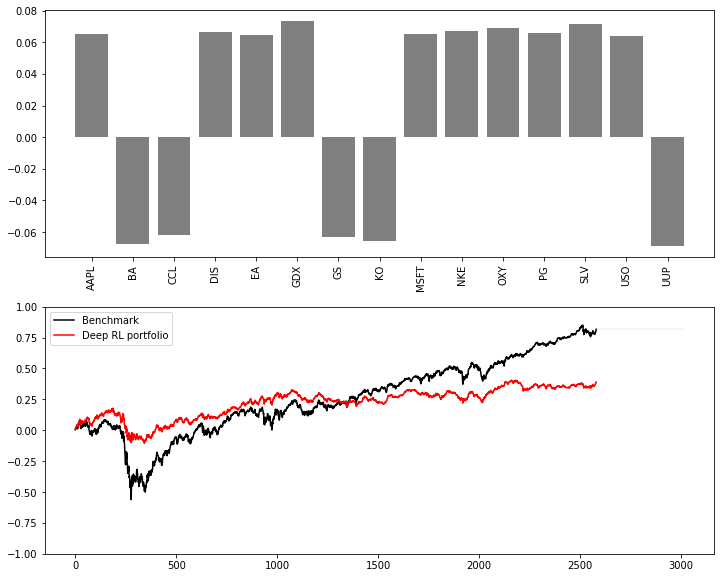

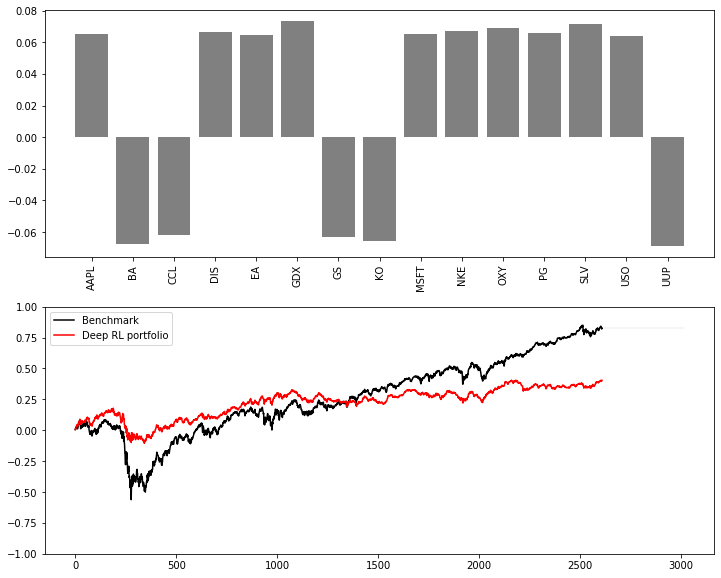

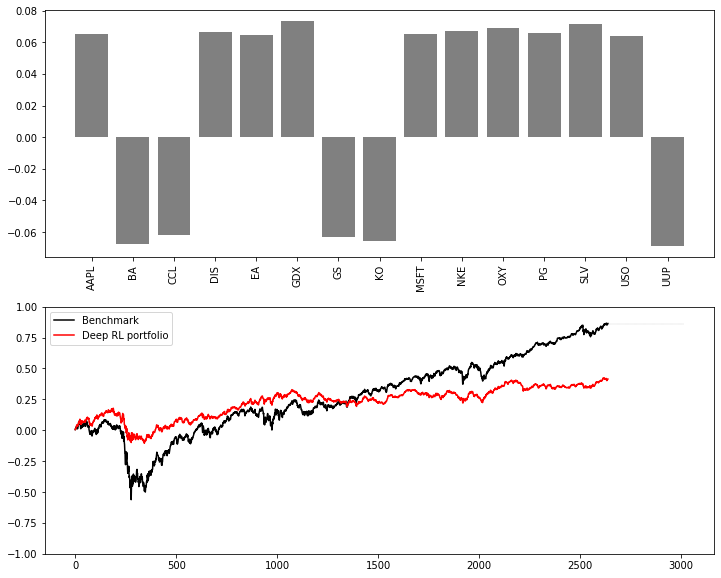

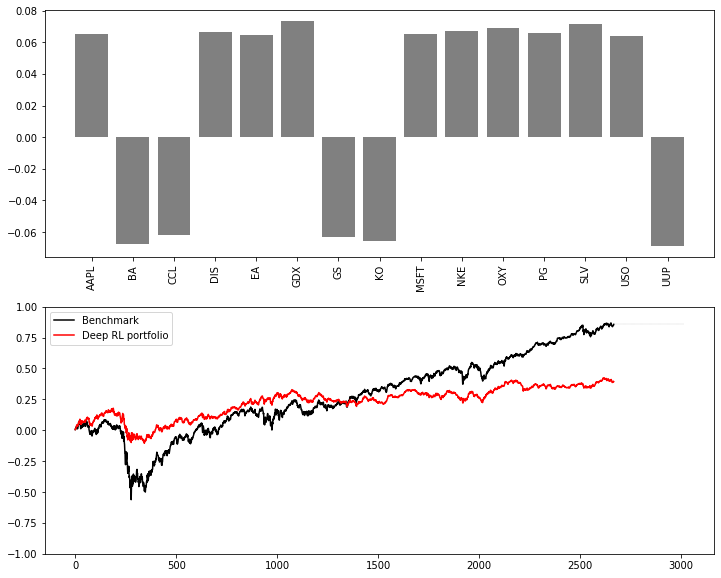

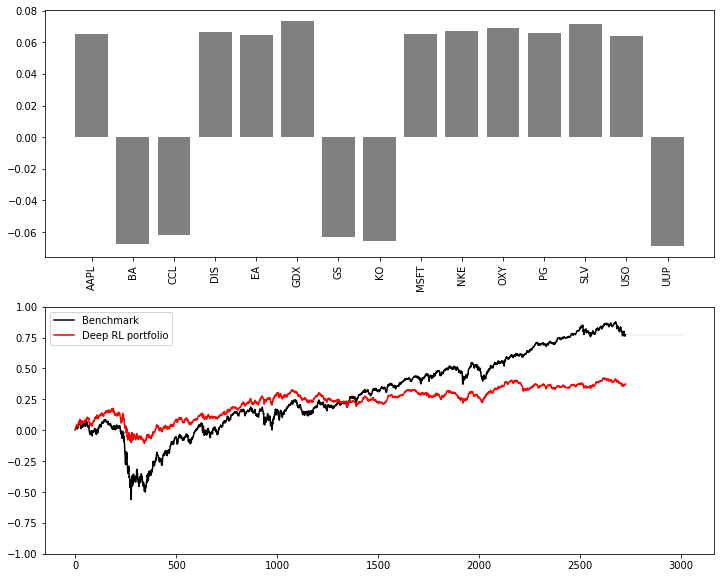

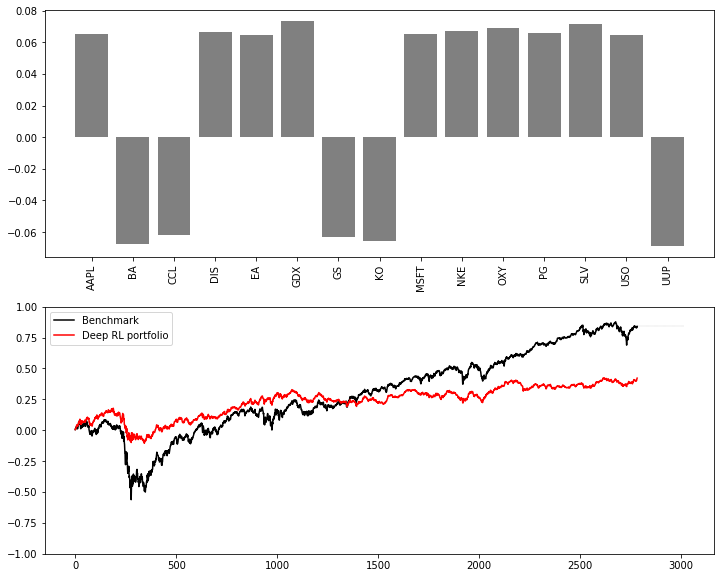

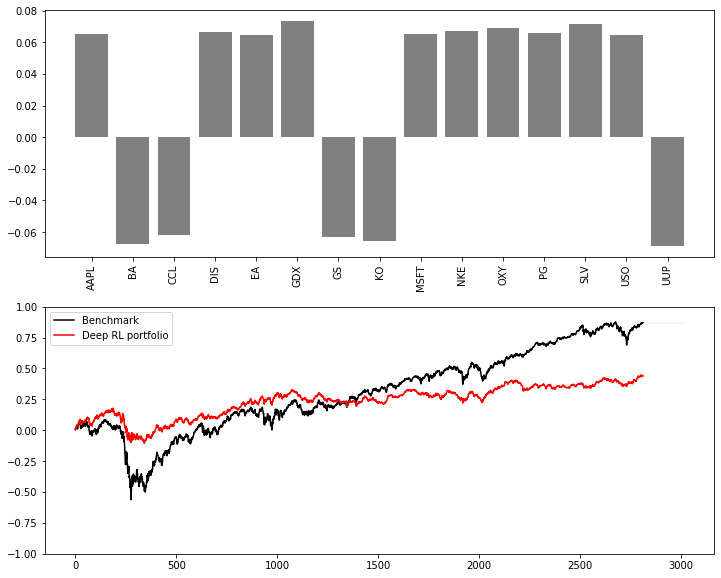

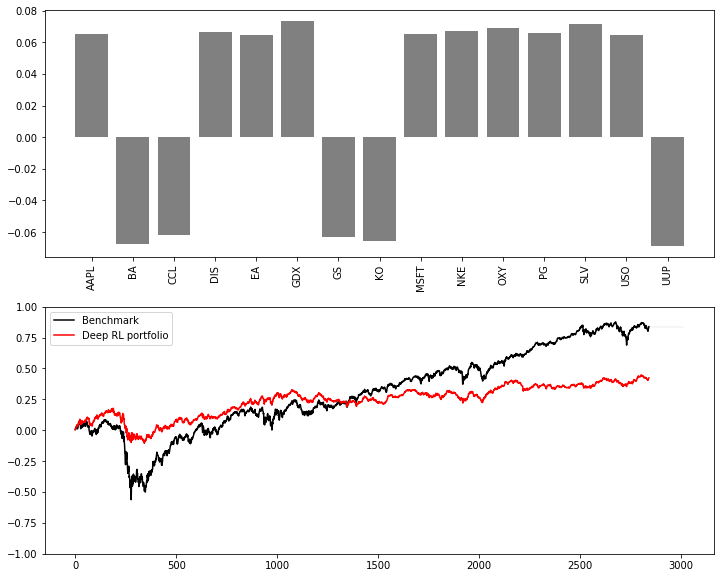

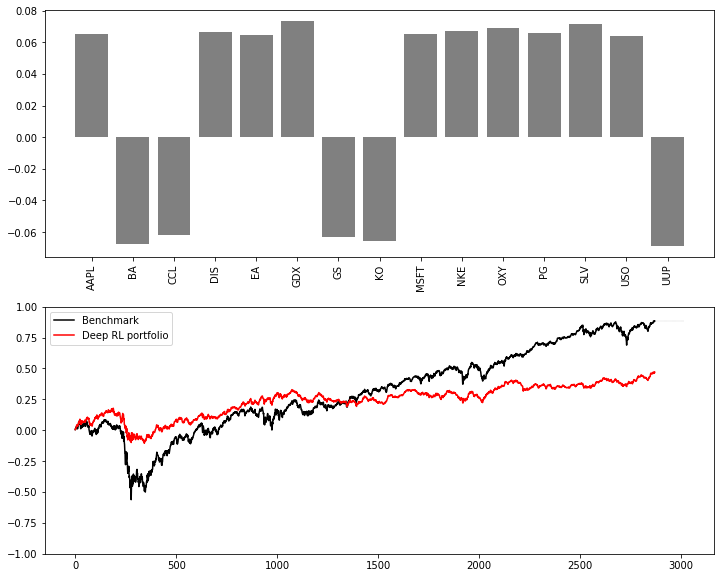

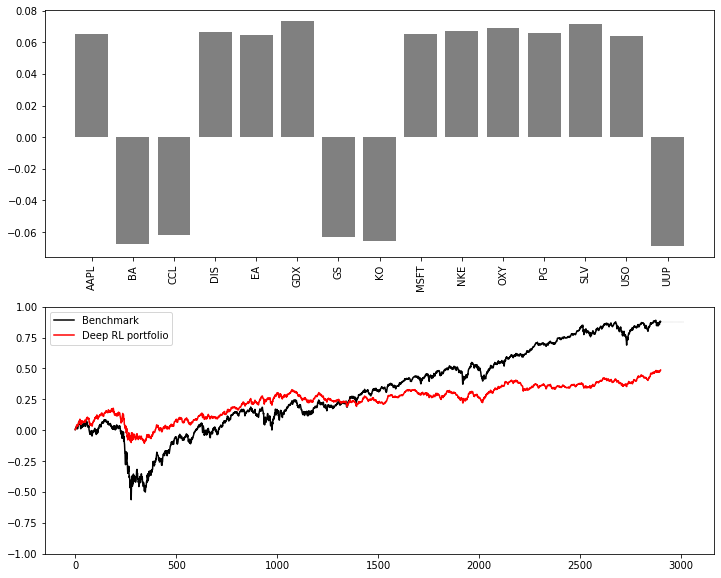

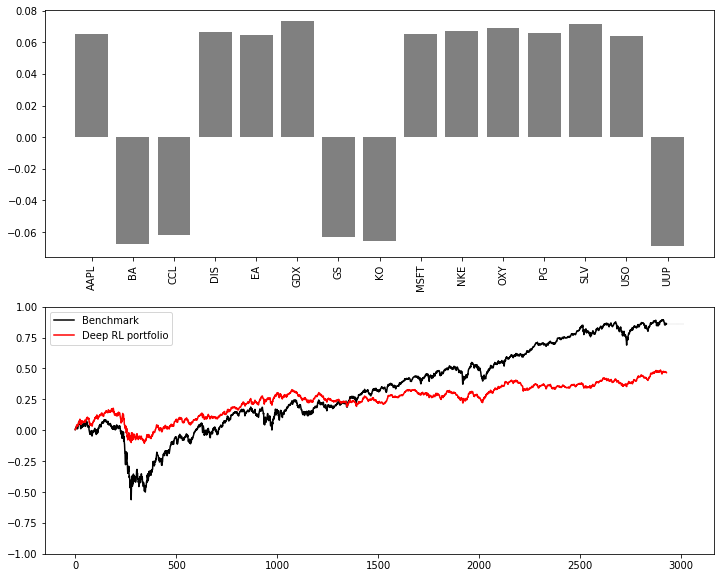

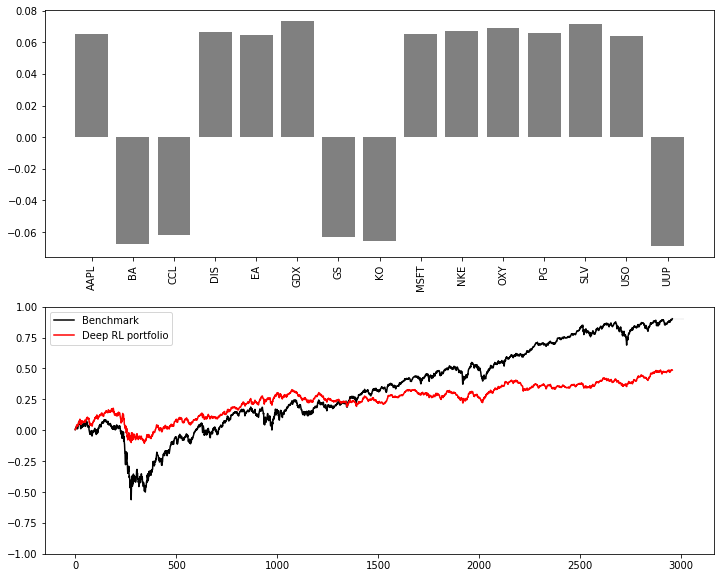

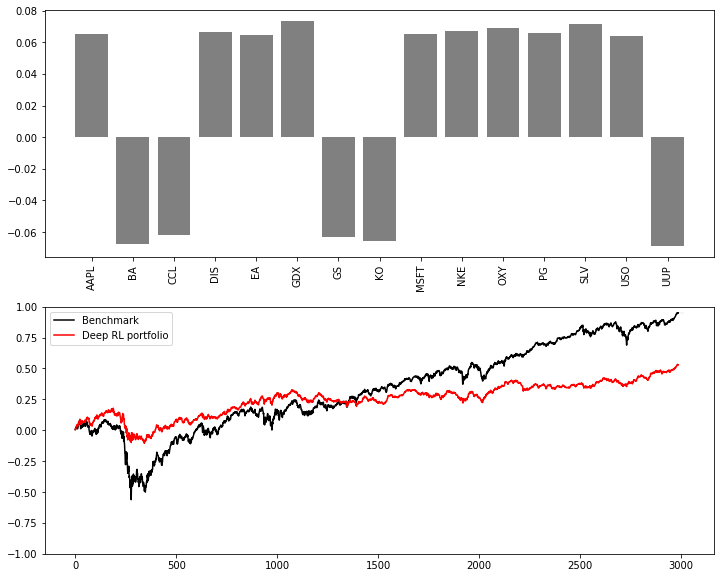

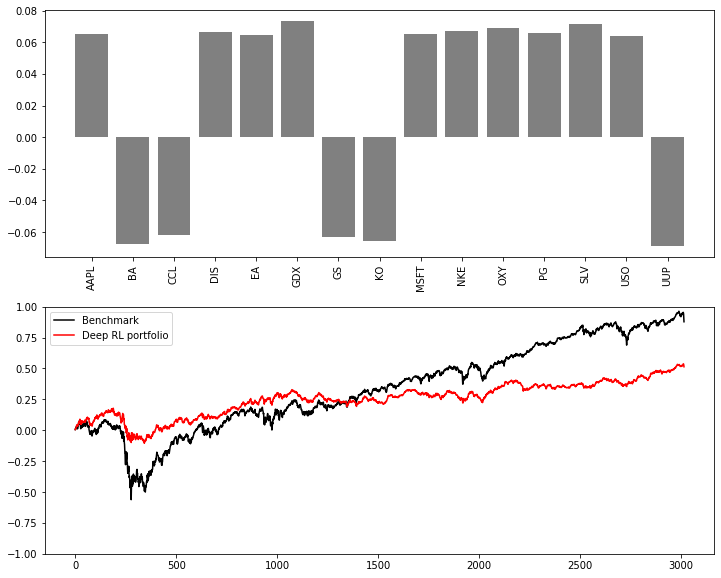

In [16]:
plot_results(result_equal, 
             result_rl, 
             actions_rl, 
             N_ASSETS,
             env.data.columns, 
             'Deep RL portfolio', './images_test1/rl/', 'series')